In [210]:
# %reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlwings as xw
import os
from skimage import measure
from matplotlib.colors import LinearSegmentedColormap
        

class Capabilities:
    def __init__(self, material, gauge):
        self.material = material
        self.gauge = gauge
        self._extract_data()

    def _extract_data(self):
        self.gauge_material = f"{self.gauge}_{self.material}"

        self.thickness = {
            '16_GLV': 0.0635,
            '14_GLV': 0.0785,
            '12_GLV': 0.1084,
            '10_GLV': 0.1382,
            '8_GLV':  0.1624,
            '16_SST': 0.0625,
            '14_SST': 0.0781,
            '12_SST': 0.1094,
            '10_SST': 0.1406,
            '8_SST':  0.1644
        }

        self.max_flange_width = {
            '16_GLV': 149.6,
            '14_GLV': 149.6,
            '12_GLV': 149.6,
            '10_GLV': 118.11,
            '8_GLV':  0,
            '16_SST': 149.6,
            '14_SST': 118.11,
            '12_SST': 108.26,
            '10_SST': 82.67,
            '8_SST':  0
        }

        self.density = {
            '16_GLV': 0.018444444444444444,
            '14_GLV': 0.022784722222222224,
            '12_GLV': 0.03146527777777777,
            '10_GLV': 0.04014583333333333,
            '8_GLV':  0.048826389,
            '16_SST': 0.0175,
            '14_SST': 0.021875,
            '12_SST': 0.030625,
            '10_SST': 0.039375,
            '8_SST':  0.048125
        }

        self.max_flange_length = 8
        self.min_flange_length = self.thickness[self.gauge_material] * 5
        self.min_throat_length = 15.75
        self.max_flat_diagonal = 157.48
        self.max_mass = 286.6
        self.max_sheet_length = 180
        self.max_sheet_width = 60

        self.MPB_max_dim = 168

        self.TL_max_length = 334.65
        self.TL_max_diagonal_width = 7.87
        self.TL_max_mass_per_length = 7.348

    def _get_constraints(self, min, max, n_points):
        # Create grid for all
        self.x = np.linspace(min, max, n_points)
        self.y = np.linspace(min, max, n_points)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        self.sheet_size_constraint = (self.X <= self.max_sheet_width) & (self.Y <= self.max_sheet_length)

        if self.gauge >= 10:
            # APB derived limits
            self.min_x = self.min_y = self.min_throat_length + 2 * (self.max_flange_length * 5/8)
            self.max_x = self.max_y = self.max_flange_width[self.gauge_material]

            # APB Constraints
            self.apb_feasible = np.zeros_like(self.X, dtype=bool)
           
            # For each point in the grid, check if it satisfies either orientation
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    x_val = self.X[i, j]
                    y_val = self.Y[i, j]
                   
                    # Normal orientation check (x,y)
                    normal_valid = (
                        (x_val >= self.min_x) and (x_val <= self.max_x) and
                        (y_val >= self.min_y) and (y_val <= self.max_y) and
                        (x_val**2 + y_val**2) <= self.max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.max_mass and
                        (x_val <= self.max_sheet_width) and (y_val <= self.max_sheet_length)
                    )
                   
                    # Rotated orientation check (y,x)
                    rotated_valid = (
                        (y_val >= self.min_x) and (y_val <= self.max_x) and
                        (x_val >= self.min_y) and (x_val <= self.max_y) and
                        (x_val**2 + y_val**2) <= self.max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.max_mass and
                        (y_val <= self.max_sheet_width) and (x_val <= self.max_sheet_length)
                    )
                   
                    # If either orientation is valid, mark this point as valid
                    self.apb_feasible[i, j] = normal_valid or rotated_valid

        # MPB Constraints: x < 168, y < 168, and sheet size constraints
        self.mpb_feasible = np.zeros_like(self.X, dtype=bool)
       
        # For each point in the grid, check if it satisfies either orientation for MPB
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                x_val = self.X[i, j]
                y_val = self.Y[i, j]
               
                # Normal orientation check (x,y)
                normal_valid = (
                    (x_val < self.MPB_max_dim) and
                    (y_val < self.MPB_max_dim) and
                    (x_val <= self.max_sheet_width) and
                    (y_val <= self.max_sheet_length)
                )
               
                # Rotated orientation check (y,x)
                rotated_valid = (
                    (y_val < self.MPB_max_dim) and
                    (x_val < self.MPB_max_dim) and
                    (y_val <= self.max_sheet_width) and
                    (x_val <= self.max_sheet_length)
                )
               
                # If either orientation is valid, mark this point as valid
                self.mpb_feasible[i, j] = normal_valid or rotated_valid
 

        # TL (Tube Laser) Constraints
        self.TL_max_width = round(3*((self.TL_max_diagonal_width**2 / 2) ** 0.5), 2)
        self.TL_feasible = np.zeros_like(self.X, dtype=bool)
       
        # For each point in the grid, check if it satisfies either orientation for TL
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                x_val = self.X[i, j]
                y_val = self.Y[i, j]
               
                # Normal orientation check (x,y)
                normal_valid = (
                    (y_val < self.TL_max_length) and
                    (x_val < self.TL_max_width) and
                    ((x_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
               
                # Rotated orientation check (y,x)
                rotated_valid = (
                    (x_val < self.TL_max_length) and
                    (y_val < self.TL_max_width) and
                    ((y_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
               
                # If either orientation is valid, mark this point as valid
                self.TL_feasible[i, j] = normal_valid or rotated_valid

    def plot_feasible_regions(self):
        self._get_constraints(1e-3, 340, 400)
        plt.figure(figsize=(10, 10))
        # Plot TL region in red
        plt.contourf(self.X, self.Y, self.TL_feasible, levels=[0.5, 1], colors=['#e74c3c'], alpha=0.5)
        # Plot MPB region in blue
        plt.contourf(self.X, self.Y, self.mpb_feasible, levels=[0.5, 1], colors=['#4f8cd6'], alpha=0.3)
        # Plot APB region in green
        if self.gauge >= 10: 
            plt.contourf(self.X, self.Y, self.apb_feasible, levels=[0.5, 1], colors=['#66c2a5'], alpha=0.7)
            
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')

        ax = plt.gca()
        title_y = 1.02
        title_x = 0.1
        ax.text(0.49 - title_x, title_y, f'Manufacturing regions for {self.gauge_material}: ', transform=ax.transAxes, 
                fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.76 - title_x, title_y, 'TL', transform=ax.transAxes, 
                color='#e74c3c', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.79 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.83 - title_x, title_y, 'MPB', transform=ax.transAxes, 
                color='#4f8cd6', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.87 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.91 - title_x, title_y, 'APB', transform=ax.transAxes, 
                color='#66c2a5', fontsize=14, ha='center', va='bottom', fontweight='bold')
        
        plt.axvline(self.max_sheet_width, color='black', linestyle='-', label=f'Max sheet dim = {self.max_sheet_width}, {self.max_sheet_length}')
        plt.axhline(self.max_sheet_length, color='black', linestyle='-')
        plt.axhline(self.max_sheet_width, color='black', linestyle='-')
        plt.axvline(self.max_sheet_length, color='black', linestyle='-')

        if self.gauge >= 10:
            theta = np.linspace(0, np.pi/2, 200)
            circle_x = self.max_flat_diagonal * np.cos(theta)
            circle_y = self.max_flat_diagonal * np.sin(theta)
            plt.plot(circle_x, circle_y, 'g-.', label=f'APB max diagonal: x² + y² = {self.max_flat_diagonal}²') 
            plt.plot(self.x, self.max_mass / (self.density[self.gauge_material] * self.x), 'g--', label=f'APB max mass: x·y·{round(self.density[self.gauge_material], 3)} = {self.max_mass}') 
            plt.axvline(self.min_x, color='g', linestyle=':', label=f'APB min: x,y = {self.min_x}')
            plt.axvline(self.max_x, color='g', linestyle=':', label=f'APB max: x,y = {self.max_x}')
            plt.axhline(self.min_y, color='g', linestyle=':')
            plt.axhline(self.max_y, color='g', linestyle=':')

        plt.axvline(self.MPB_max_dim, color='#4f8cd6', linestyle=':', label=f'MPB max: x,y = {self.MPB_max_dim}')
        plt.axhline(self.MPB_max_dim, color='#4f8cd6', linestyle=':')
        
        plt.axvline(self.TL_max_width, color='#e74c3c', linestyle=':', label=f'TL max: x = {self.TL_max_width}')
        plt.axhline(self.TL_max_length, color='#e74c3c', linestyle=':', label=f'TL max: y = {self.TL_max_length}')
        plt.axvline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--', label=f'TL max mass: x·{round(self.density[self.gauge_material], 3)} = {self.TL_max_mass_per_length}')
        plt.axvline(self.TL_max_length, color='#e74c3c', linestyle=':')
        plt.axhline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--')

        plt.xlim(0, 340)
        plt.ylim(0, 340)
    
    def add_part_sets(self, part_sets_df):
        """Plot part sets on the current figure"""
        
        def process_material(material_str):
            return str(material_str)[:3]
        
        # Define a list of colors to use for different part sets
        colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple', 'brown', 'teal', 'magenta', 'black']
        markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
        
        for i, part_set_df in enumerate(part_sets_df):
            part_set_df['Material'] = part_set_df['NCx_Material'].apply(process_material)
            
            # Filter for current gauge and material combination
            current_parts = part_set_df[
                (part_set_df['Gauge'] == self.gauge) & 
                (part_set_df['Material'] == self.material)
            ]
            
            if not current_parts.empty:
                x_coords = pd.to_numeric(current_parts['CostData FlatWidthInches'], errors='coerce')
                y_coords = pd.to_numeric(current_parts['CostData FlatLengthInches'], errors='coerce')
                
                # Remove NaN values
                valid_coords = ~(pd.isna(x_coords) | pd.isna(y_coords))
                x_coords = x_coords[valid_coords]
                y_coords = y_coords[valid_coords]
                
                if len(x_coords) > 0:
                    # Use the color and marker based on the index i (cycling through the colors/markers if needed)
                    color = colors[i % len(colors)]
                    marker = markers[i % len(markers)]
                    
                    plt.scatter(x_coords, y_coords, c=color, marker=marker, s=60, 
                                label=f'{part_set_df['Part Set'].iloc[0]} - {len(x_coords)} parts', alpha=0.8, edgecolors='white')
                
    def show_plot(self):
        plt.legend(loc='upper right')
        plt.show()

    def plot_individual_cost_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        self._get_constraints(-1, 341, 69)
        
        cost_cells = {
            'Total Cost': 'U',  # Column letter only, row will be added
        }
        input_cols = {
            'length': 'L',
            'width': 'M',
            'quantity': 'C',
            'process1': 'D',
            'process2': 'E',
            'material_code': 'F',
            'gauge': 'G',
            'fastener_count': 'H',
            'perimeter_plus_fastener': 'I',
            'J': 'J',
            'K': 'K',
            'N': 'N'
        }
        
        if self.gauge >= 10:
            region_inputs = {
                'apb': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }

            region_masks = {
                'apb': self.apb_feasible,
                'mpb': self.mpb_feasible,
                'tl': self.TL_feasible
            }
        else:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }

            region_masks = {
                'mpb': self.mpb_feasible,
                'tl': self.TL_feasible
            }

        all_costs = {}

        for region, (proc1, proc2, fastener_func) in region_inputs.items():
            print(f"Generating heatmap for region: {region.upper()}")
            mask = region_masks[region]
            print(f"Number of feasible points: {np.sum(mask)}")

            # Prepare input data for all feasible points
            points = np.argwhere(mask)
            num_points = points.shape[0]
            if num_points == 0:
                print("No feasible points for this region.")
                all_costs[region] = np.full(self.X.shape, np.nan)
                continue

            # Prepare input arrays
            lengths = [int(self.Y[i, j]) for i, j in points]
            widths = [int(self.X[i, j]) for i, j in points]
            quantities = [1] * num_points
            process1s = [proc1] * num_points
            process2s = [proc2] * num_points
            material_codes = ['GLV-M5' if self.material == 'GLV' else 'SST-M3'] * num_points
            gauges_list = [self.gauge] * num_points
            fastener_counts = [fastener_func(l, w) for l, w in zip(lengths, widths)]
            perim_plus_fastener = [
                2*l + 2*w + fc*np.pi*bolt_diameter
                for l, w, fc in zip(lengths, widths, fastener_counts)
            ]
            Js = [4] * num_points
            Ks = [4] * num_points
            Ns = ["Class 2"] * num_points

            app = None
            wb = None
            try:
                app = xw.App(visible=False)
                wb = app.books.open(excel_path)
                ws = wb.sheets['BAC Part List']
                print("Workbook opened successfully.")

                # Write all inputs in batch
                start_row = 150
                end_row = start_row + num_points - 1
                ws.range(f"{input_cols['length']}{start_row}:{input_cols['length']}{end_row}").value = [[v] for v in lengths]
                ws.range(f"{input_cols['width']}{start_row}:{input_cols['width']}{end_row}").value = [[v] for v in widths]
                ws.range(f"{input_cols['quantity']}{start_row}:{input_cols['quantity']}{end_row}").value = [[v] for v in quantities]
                ws.range(f"{input_cols['process1']}{start_row}:{input_cols['process1']}{end_row}").value = [[v] for v in process1s]
                ws.range(f"{input_cols['process2']}{start_row}:{input_cols['process2']}{end_row}").value = [[v] for v in process2s]
                ws.range(f"{input_cols['material_code']}{start_row}:{input_cols['material_code']}{end_row}").value = [[v] for v in material_codes]
                ws.range(f"{input_cols['gauge']}{start_row}:{input_cols['gauge']}{end_row}").value = [[v] for v in gauges_list]
                ws.range(f"{input_cols['fastener_count']}{start_row}:{input_cols['fastener_count']}{end_row}").value = [[v] for v in fastener_counts]
                ws.range(f"{input_cols['perimeter_plus_fastener']}{start_row}:{input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in perim_plus_fastener]
                ws.range(f"{input_cols['J']}{start_row}:{input_cols['J']}{end_row}").value = [[v] for v in Js]
                ws.range(f"{input_cols['K']}{start_row}:{input_cols['K']}{end_row}").value = [[v] for v in Ks]
                ws.range(f"{input_cols['N']}{start_row}:{input_cols['N']}{end_row}").value = [[v] for v in Ns]

                wb.app.calculate()  # Force recalculation

                # Read all costs in batch
                costs_arr = np.full(self.X.shape, np.nan)
                cost_col = cost_cells['Total Cost']
                cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
                if isinstance(cost_range, list) and isinstance(cost_range[0], list):
                    cost_range = [row[0] for row in cost_range]
                for idx, (i, j) in enumerate(points):
                    val = cost_range[idx]
                    costs_arr[i, j] = val if isinstance(val, (int, float)) else np.nan                    
                all_costs[region] = costs_arr

            finally:
                if wb is not None:
                    # Clear the input data rows before closing
                    if num_points > 0:
                        clear_start_row = 150
                        clear_end_row = 150 + num_points - 1
                        # Clear all input columns for the used rows
                        for col in input_cols.values():
                            ws.range(f"{col}{clear_start_row}:{col}{clear_end_row}").clear_contents()
                    wb.close()
                if app is not None:
                    app.quit()
                print("Workbook processed and closed.")

        # After all regions, determine global min/max for color scale
        all_costs_flat = np.concatenate([arr[~np.isnan(arr)] for arr in all_costs.values() if arr is not None])
        if all_costs_flat.size > 0:
            fixed_vmin = 0
            fixed_vmax = 900
        else:
            fixed_vmin, fixed_vmax = 0, 1  # fallback
        
        region_colors = {
            'apb': '#66c2a5',
            'mpb': '#4f8cd6',
            'tl': '#e74c3c'
        }

        # Create custom greyscale colormap starting from light grey
        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)

        # Plot all heatmaps with the same scale and axes
        for region, arr in all_costs.items():
            plt.figure(figsize=(10, 8))
            masked_arr = np.ma.masked_invalid(arr)
            plt.imshow(masked_arr, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                    cmap=cmap, vmin=fixed_vmin, vmax=fixed_vmax)
            plt.colorbar(label='Total Cost ($)')
            plt.xlabel('Width (in)')
            plt.ylabel('Length (in)')
            plt.suptitle(f'Total Cost Heatmap\nGauge: {self.gauge}, Material: {self.material}, Region: ', 
                        fontsize=14, fontweight='bold', color='black', y=0.95)
            plt.figtext(0.688, 0.902, f'{region.upper()}', fontsize=14, fontweight='bold', 
                       color=region_colors.get(region, 'black'), ha='left')
            plt.xlim(0, 340)
            plt.ylim(0, 340)
            plt.show()
    
    def plot_optimal_cost_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        self._get_constraints(-1, 341, 69)
        
        cost_cells = {
            'Total Cost': 'U',  # Column letter only, row will be added
        }
        input_cols = {
            'length': 'L',
            'width': 'M',
            'quantity': 'C',
            'process1': 'D',
            'process2': 'E',
            'material_code': 'F',
            'gauge': 'G',
            'fastener_count': 'H',
            'perimeter_plus_fastener': 'I',
            'J': 'J',
            'K': 'K',
            'N': 'N'
        }
        
        if self.gauge >= 10:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'apb': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }

            region_masks = {
                'mpb': self.mpb_feasible,
                'apb': self.apb_feasible,
                'tl': self.TL_feasible
            }
        else:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }

            region_masks = {
                'mpb': self.mpb_feasible,
                'tl': self.TL_feasible
            }

        all_costs = {}
        all_points = {}

        # Get costs for each region (same as generate_cost_heatmaps)
        for region, (proc1, proc2, fastener_func) in region_inputs.items():
            print(f"Generating costs for region: {region.upper()}")
            mask = region_masks[region]
            print(f"Number of feasible points: {np.sum(mask)}")

            # Prepare input data for all feasible points
            points = np.argwhere(mask)
            all_points[region] = points
            num_points = points.shape[0]
            if num_points == 0:
                print("No feasible points for this region.")
                all_costs[region] = np.full(self.X.shape, np.nan)
                continue

            # Prepare input arrays
            lengths = [int(self.Y[i, j]) for i, j in points]
            widths = [int(self.X[i, j]) for i, j in points]
            quantities = [1] * num_points
            process1s = [proc1] * num_points
            process2s = [proc2] * num_points
            material_codes = ['GLV-M5' if self.material == 'GLV' else 'SST-M3'] * num_points
            gauges_list = [self.gauge] * num_points
            fastener_counts = [fastener_func(l, w) for l, w in zip(lengths, widths)]
            perim_plus_fastener = [
                2*l + 2*w + fc*np.pi*bolt_diameter
                for l, w, fc in zip(lengths, widths, fastener_counts)
            ]
            Js = [4] * num_points
            Ks = [4] * num_points
            Ns = ["Class 2"] * num_points

            app = None
            wb = None
            try:
                app = xw.App(visible=False)
                wb = app.books.open(excel_path)
                ws = wb.sheets['BAC Part List']
                print("Workbook opened successfully.")

                # Write all inputs in batch
                start_row = 150
                end_row = start_row + num_points - 1
                ws.range(f"{input_cols['length']}{start_row}:{input_cols['length']}{end_row}").value = [[v] for v in lengths]
                ws.range(f"{input_cols['width']}{start_row}:{input_cols['width']}{end_row}").value = [[v] for v in widths]
                ws.range(f"{input_cols['quantity']}{start_row}:{input_cols['quantity']}{end_row}").value = [[v] for v in quantities]
                ws.range(f"{input_cols['process1']}{start_row}:{input_cols['process1']}{end_row}").value = [[v] for v in process1s]
                ws.range(f"{input_cols['process2']}{start_row}:{input_cols['process2']}{end_row}").value = [[v] for v in process2s]
                ws.range(f"{input_cols['material_code']}{start_row}:{input_cols['material_code']}{end_row}").value = [[v] for v in material_codes]
                ws.range(f"{input_cols['gauge']}{start_row}:{input_cols['gauge']}{end_row}").value = [[v] for v in gauges_list]
                ws.range(f"{input_cols['fastener_count']}{start_row}:{input_cols['fastener_count']}{end_row}").value = [[v] for v in fastener_counts]
                ws.range(f"{input_cols['perimeter_plus_fastener']}{start_row}:{input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in perim_plus_fastener]
                ws.range(f"{input_cols['J']}{start_row}:{input_cols['J']}{end_row}").value = [[v] for v in Js]
                ws.range(f"{input_cols['K']}{start_row}:{input_cols['K']}{end_row}").value = [[v] for v in Ks]
                ws.range(f"{input_cols['N']}{start_row}:{input_cols['N']}{end_row}").value = [[v] for v in Ns]

                wb.app.calculate()  # Force recalculation

                # Read all costs in batch
                costs_arr = np.full(self.X.shape, np.nan)
                cost_col = cost_cells['Total Cost']
                cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
                if isinstance(cost_range, list) and isinstance(cost_range[0], list):
                    cost_range = [row[0] for row in cost_range]
                for idx, (i, j) in enumerate(points):
                    val = cost_range[idx]
                    costs_arr[i, j] = val if isinstance(val, (int, float)) else np.nan                    
                all_costs[region] = costs_arr

            finally:
                if wb is not None:
                    # Clear the input data rows before closing
                    if num_points > 0:
                        clear_start_row = 150
                        clear_end_row = 150 + num_points - 1
                        # Clear all input columns for the used rows
                        for col in input_cols.values():
                            ws.range(f"{col}{clear_start_row}:{col}{clear_end_row}").clear_contents()
                    wb.close()
                if app is not None:
                    app.quit()
                print("Workbook processed and closed.")

        # Create combined optimal cost matrix and process tracking matrix
        optimal_costs = np.full(self.X.shape, np.nan)
        optimal_process = np.full(self.X.shape, '', dtype=object)

        # For each point, find the minimum cost across all feasible regions
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                min_cost = np.inf
                best_process = None
                
                for region in all_costs:
                    cost = all_costs[region][i, j]
                    if not np.isnan(cost) and cost < min_cost:
                        min_cost = cost
                        best_process = region
                
                if best_process is not None:
                    optimal_costs[i, j] = min_cost
                    optimal_process[i, j] = best_process

        # Calculate comprehensive statistics for optimal regions only
        print("\n" + "="*80)
        print("COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS")
        print("="*80)
        
        region_stats = {}
        grid_area_per_point = (340/69)**2  # Approximate area per grid point
        
        for region in region_inputs.keys():
            # Get costs where this region is optimal
            optimal_mask = (optimal_process == region)
            optimal_region_costs = optimal_costs[optimal_mask]
            
            if len(optimal_region_costs) > 0:
                # Calculate all statistics
                stats = {
                    'min_cost': np.min(optimal_region_costs),
                    'max_cost': np.max(optimal_region_costs),
                    'avg_cost': np.mean(optimal_region_costs),
                    'median_cost': np.median(optimal_region_costs),
                    'std_cost': np.std(optimal_region_costs),
                    'percentile_25': np.percentile(optimal_region_costs, 25),
                    'percentile_75': np.percentile(optimal_region_costs, 75),
                    'optimal_points': len(optimal_region_costs),
                    'optimal_area_sq_in': len(optimal_region_costs) * grid_area_per_point,
                    'cost_per_sq_in': np.mean(optimal_region_costs) / grid_area_per_point
                }
                
                region_stats[region] = stats
                
                # Print detailed statistics
                print(f"\n{region.upper()} OPTIMAL REGION STATISTICS:")
                print(f"  Coverage:")
                print(f"    • Optimal points: {stats['optimal_points']:,}")
                print(f"    • Optimal area: {stats['optimal_area_sq_in']:,.0f} sq in")
                print(f"    • Cost per sq in: ${stats['cost_per_sq_in']:.4f}")
                
                print(f"  Cost Distribution:")
                print(f"    • Minimum cost: ${stats['min_cost']:.2f}")
                print(f"    • Maximum cost: ${stats['max_cost']:.2f}")
                print(f"    • Average cost: ${stats['avg_cost']:.2f}")
                print(f"    • Median cost: ${stats['median_cost']:.2f}")
                print(f"    • Standard deviation: ${stats['std_cost']:.2f}")
                print(f"    • 25th percentile: ${stats['percentile_25']:.2f}")
                print(f"    • 75th percentile: ${stats['percentile_75']:.2f}")
                print(f"    • Cost range span: ${stats['max_cost'] - stats['min_cost']:.2f}")
                print(f"    • Coefficient of variation: {(stats['std_cost']/stats['avg_cost'])*100:.1f}%")
                
            else:
                print(f"\n{region.upper()} REGION: Never optimal")
                region_stats[region] = None

        # Overall summary
        print(f"\n" + "="*80)
        print("OVERALL OPTIMAL COST SUMMARY")
        print("="*80)
        all_optimal_costs = optimal_costs[~np.isnan(optimal_costs)]
        if len(all_optimal_costs) > 0:
            total_area = len(all_optimal_costs) * grid_area_per_point
            
            print(f"Global Statistics:")
            print(f"  • Total feasible area: {total_area:,.0f} sq in")
            print(f"  • Global cost range: ${np.min(all_optimal_costs):.2f} - ${np.max(all_optimal_costs):.2f}")
            print(f"  • Overall average cost: ${np.mean(all_optimal_costs):.2f}")
            print(f"  • Overall median cost: ${np.median(all_optimal_costs):.2f}")
            print(f"  • Overall std deviation: ${np.std(all_optimal_costs):.2f}")
            
            # Process dominance analysis
            unique_processes, counts = np.unique(optimal_process[optimal_process != ''], return_counts=True)
            print(f"\nProcess Dominance Analysis:")
            for process, count in zip(unique_processes, counts):
                percentage = (count / len(all_optimal_costs)) * 100
                area = count * grid_area_per_point
                print(f"  • {process.upper()}: {percentage:.1f}% coverage ({area:,.0f} sq in, {count:,} points)")
            
            # Cost transition analysis
            print(f"\nCost Transition Points:")
            for i, (process, count) in enumerate(zip(unique_processes, counts)):
                if region_stats[process] is not None:
                    boundary_costs = []
                    # Sample costs near boundaries (simplified approach)
                    process_mask = (optimal_process == process)
                    process_costs = optimal_costs[process_mask]
                    if len(process_costs) > 10:
                        # Get costs at boundary percentiles
                        boundary_costs = [
                            np.percentile(process_costs, 10),
                            np.percentile(process_costs, 90)
                        ]
                        print(f"    • {process.upper()} boundary cost range: ${boundary_costs[0]:.2f} - ${boundary_costs[1]:.2f}")

        # Determine global min/max for color scale
        all_costs_flat = optimal_costs[~np.isnan(optimal_costs)]
        if all_costs_flat.size > 0:
            fixed_vmin = np.nanmin(all_costs_flat)
            fixed_vmax = np.nanmax(all_costs_flat)
        else:
            fixed_vmin, fixed_vmax = 0, 1  # fallback

        # Define region colors for boundaries
        region_colors = {
            'mpb': '#1e90ff',
            'apb': '#00ff7f',
            'tl': '#ff4500'
        }

        # Create custom greyscale colormap starting from light grey
        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)

        # Create the combined plot
        plt.figure(figsize=(12, 10))
        
        # Plot the cost heatmap
        masked_arr = np.ma.masked_invalid(optimal_costs)
        plt.imshow(masked_arr, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                cmap=cmap, vmin=fixed_vmin, vmax=fixed_vmax)
        plt.colorbar(label='Total Cost ($)')
        
        # Add boundary lines for process regions
        for region in region_inputs.keys():
            # Create a binary mask for this process being optimal
            process_mask = (optimal_process == region).astype(int)
            
            if np.any(process_mask):
                # Pad the mask to handle edge cases
                padded_mask = np.pad(process_mask, pad_width=1, mode='constant', constant_values=0)
                # Find contours on the padded mask
                contours = measure.find_contours(padded_mask, 0.5)
                
                for contour in contours:
                    # Convert contour coordinates to plot coordinates
                    y_coords = (contour[:, 0] - 0.5) * (340 / self.X.shape[0])
                    x_coords = (contour[:, 1] - 0.42) * (340 / self.X.shape[1])
                    
                    plt.plot(x_coords, y_coords, color=region_colors[region], 
                            linewidth=2, alpha=1.0, label=f'{region.upper()} boundary')

        # Remove duplicate labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')
        plt.suptitle(f'Optimal Manufacturing Process Cost Comparison\nGauge: {self.gauge}, Material: {self.material}', 
                    fontsize=14, fontweight='bold', color='black', y=0.95)
        plt.xlim(0, 340)
        plt.ylim(0, 340)
        plt.show()
        
        return region_stats

    def plot_cost_difference_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        """
        Analyze cost differences between manufacturing processes in regions with multiple feasible options.
        Shows boundaries colored by process and displays absolute cost differences.
        """
        
        self._get_constraints(-1, 341, 69)
        
        cost_cells = {'Total Cost': 'U'}
        input_cols = {
            'length': 'L', 'width': 'M', 'quantity': 'C', 'process1': 'D', 'process2': 'E',
            'material_code': 'F', 'gauge': 'G', 'fastener_count': 'H', 
            'perimeter_plus_fastener': 'I', 'J': 'J', 'K': 'K', 'N': 'N'
        }
        
        if self.gauge >= 10:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'apb': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }
            region_masks = {
                'mpb': self.mpb_feasible,
                'apb': self.apb_feasible,
                'tl': self.TL_feasible
            }
        else:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }
            region_masks = {
                'mpb': self.mpb_feasible,
                'tl': self.TL_feasible
            }

        # Get costs for each region (same logic as process_cost_comparison)
        all_costs = {}
        
        for region, (proc1, proc2, fastener_func) in region_inputs.items():
            print(f"Generating costs for region: {region.upper()}")
            mask = region_masks[region]
            print(f"Number of feasible points: {np.sum(mask)}")

            points = np.argwhere(mask)
            num_points = points.shape[0]
            if num_points == 0:
                print("No feasible points for this region.")
                all_costs[region] = np.full(self.X.shape, np.nan)
                continue

            # Prepare input arrays
            lengths = [int(self.Y[i, j]) for i, j in points]
            widths = [int(self.X[i, j]) for i, j in points]
            quantities = [1] * num_points
            process1s = [proc1] * num_points
            process2s = [proc2] * num_points
            material_codes = ['GLV-M5' if self.material == 'GLV' else 'SST-M3'] * num_points
            gauges_list = [self.gauge] * num_points
            fastener_counts = [fastener_func(l, w) for l, w in zip(lengths, widths)]
            perim_plus_fastener = [
                2*l + 2*w + fc*np.pi*bolt_diameter
                for l, w, fc in zip(lengths, widths, fastener_counts)
            ]
            Js = [4] * num_points
            Ks = [4] * num_points
            Ns = ["Class 2"] * num_points

            app = None
            wb = None
            try:
                app = xw.App(visible=False)
                wb = app.books.open(excel_path)
                ws = wb.sheets['BAC Part List']
                print("Workbook opened successfully.")

                # Write all inputs in batch
                start_row = 150
                end_row = start_row + num_points - 1
                ws.range(f"{input_cols['length']}{start_row}:{input_cols['length']}{end_row}").value = [[v] for v in lengths]
                ws.range(f"{input_cols['width']}{start_row}:{input_cols['width']}{end_row}").value = [[v] for v in widths]
                ws.range(f"{input_cols['quantity']}{start_row}:{input_cols['quantity']}{end_row}").value = [[v] for v in quantities]
                ws.range(f"{input_cols['process1']}{start_row}:{input_cols['process1']}{end_row}").value = [[v] for v in process1s]
                ws.range(f"{input_cols['process2']}{start_row}:{input_cols['process2']}{end_row}").value = [[v] for v in process2s]
                ws.range(f"{input_cols['material_code']}{start_row}:{input_cols['material_code']}{end_row}").value = [[v] for v in material_codes]
                ws.range(f"{input_cols['gauge']}{start_row}:{input_cols['gauge']}{end_row}").value = [[v] for v in gauges_list]
                ws.range(f"{input_cols['fastener_count']}{start_row}:{input_cols['fastener_count']}{end_row}").value = [[v] for v in fastener_counts]
                ws.range(f"{input_cols['perimeter_plus_fastener']}{start_row}:{input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in perim_plus_fastener]
                ws.range(f"{input_cols['J']}{start_row}:{input_cols['J']}{end_row}").value = [[v] for v in Js]
                ws.range(f"{input_cols['K']}{start_row}:{input_cols['K']}{end_row}").value = [[v] for v in Ks]
                ws.range(f"{input_cols['N']}{start_row}:{input_cols['N']}{end_row}").value = [[v] for v in Ns]

                wb.app.calculate()

                # Read all costs in batch
                costs_arr = np.full(self.X.shape, np.nan)
                cost_col = cost_cells['Total Cost']
                cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
                if isinstance(cost_range, list) and isinstance(cost_range[0], list):
                    cost_range = [row[0] for row in cost_range]
                for idx, (i, j) in enumerate(points):
                    val = cost_range[idx]
                    costs_arr[i, j] = val if isinstance(val, (int, float)) else np.nan                    
                all_costs[region] = costs_arr

            finally:
                if wb is not None:
                    if num_points > 0:
                        clear_start_row = 150
                        clear_end_row = 150 + num_points - 1
                        for col in input_cols.values():
                            ws.range(f"{col}{clear_start_row}:{col}{clear_end_row}").clear_contents()
                    wb.close()
                if app is not None:
                    app.quit()
                print("Workbook processed and closed.")

        # Find regions with multiple feasible processes and calculate cost differences
        print("Analyzing regions with multiple feasible processes...")
        
        optimal_costs = np.full(self.X.shape, np.nan)
        optimal_process = np.full(self.X.shape, '', dtype=object)
        cost_differences = np.full(self.X.shape, np.nan)
        multi_process_mask = np.full(self.X.shape, False, dtype=bool)

        # For each point, find regions with multiple processes and calculate differences
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                # Get all valid costs for this point
                point_costs = {}
                for region in all_costs:
                    cost = all_costs[region][i, j]
                    if not np.isnan(cost):
                        point_costs[region] = cost
                
                # Only analyze points with 2+ feasible processes
                if len(point_costs) >= 2:
                    multi_process_mask[i, j] = True
                    
                    # Find optimal and second-best costs
                    sorted_costs = sorted(point_costs.items(), key=lambda x: x[1])
                    best_process, best_cost = sorted_costs[0]
                    second_best_process, second_best_cost = sorted_costs[1]
                    
                    optimal_costs[i, j] = best_cost
                    optimal_process[i, j] = best_process
                    cost_differences[i, j] = second_best_cost - best_cost
                    
        print(f"Found {np.sum(multi_process_mask)} points with multiple feasible processes")

        # Calculate comprehensive statistics for optimal regions in competitive areas
        print("\n" + "="*80)
        print("COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS")
        print("="*80)
        
        region_stats = {}
        grid_area_per_point = (340/69)**2  # Approximate area per grid point
        
        for region in region_inputs.keys():
            # Get costs where this region is optimal in multi-process areas
            optimal_mask = (optimal_process == region) & multi_process_mask
            optimal_region_costs = optimal_costs[optimal_mask]
            optimal_differences = cost_differences[optimal_mask]
            
            if len(optimal_region_costs) > 0:
                # Calculate comprehensive statistics
                stats = {
                    'min_cost': np.min(optimal_region_costs),
                    'max_cost': np.max(optimal_region_costs),
                    'avg_cost': np.mean(optimal_region_costs),
                    'median_cost': np.median(optimal_region_costs),
                    'std_cost': np.std(optimal_region_costs),
                    'percentile_25': np.percentile(optimal_region_costs, 25),
                    'percentile_75': np.percentile(optimal_region_costs, 75),
                    'optimal_points': len(optimal_region_costs),
                    'optimal_area_sq_in': len(optimal_region_costs) * grid_area_per_point,
                    'cost_per_sq_in': np.mean(optimal_region_costs) / grid_area_per_point,
                    'win_rate': (len(optimal_region_costs) / np.sum(multi_process_mask)) * 100,
                    'min_advantage': np.min(optimal_differences),
                    'max_advantage': np.max(optimal_differences),
                    'avg_advantage': np.mean(optimal_differences),
                    'median_advantage': np.median(optimal_differences),
                    'std_advantage': np.std(optimal_differences),
                    'advantage_25th': np.percentile(optimal_differences, 25),
                    'advantage_75th': np.percentile(optimal_differences, 75)
                }
                
                region_stats[region] = stats
                
                # Print detailed statistics
                print(f"\n{region.upper()} OPTIMAL REGION (COMPETITIVE AREAS):")
                print(f"  Coverage & Performance:")
                print(f"    • Times optimal: {stats['optimal_points']:,}")
                print(f"    • Win rate: {stats['win_rate']:.1f}%")
                print(f"    • Optimal area: {stats['optimal_area_sq_in']:,.0f} sq in")
                print(f"    • Cost per sq in: ${stats['cost_per_sq_in']:.4f}")
                
                print(f"  Cost Distribution When Optimal:")
                print(f"    • Minimum cost: ${stats['min_cost']:.2f}")
                print(f"    • Maximum cost: ${stats['max_cost']:.2f}")
                print(f"    • Average cost: ${stats['avg_cost']:.2f}")
                print(f"    • Median cost: ${stats['median_cost']:.2f}")
                print(f"    • Standard deviation: ${stats['std_cost']:.2f}")
                print(f"    • 25th percentile: ${stats['percentile_25']:.2f}")
                print(f"    • 75th percentile: ${stats['percentile_75']:.2f}")
                print(f"    • Cost range span: ${stats['max_cost'] - stats['min_cost']:.2f}")
                print(f"    • Coefficient of variation: {(stats['std_cost']/stats['avg_cost'])*100:.1f}%")
                
                print(f"  Competitive Advantage:")
                print(f"    • Minimum advantage: ${stats['min_advantage']:.2f}")
                print(f"    • Maximum advantage: ${stats['max_advantage']:.2f}")
                print(f"    • Average advantage: ${stats['avg_advantage']:.2f}")
                print(f"    • Median advantage: ${stats['median_advantage']:.2f}")
                print(f"    • Advantage std dev: ${stats['std_advantage']:.2f}")
                print(f"    • Advantage 25th percentile: ${stats['advantage_25th']:.2f}")
                print(f"    • Advantage 75th percentile: ${stats['advantage_75th']:.2f}")
                print(f"    • Advantage range span: ${stats['max_advantage'] - stats['min_advantage']:.2f}")
                
            else:
                print(f"\n{region.upper()} REGION: Never optimal in competitive areas")
                region_stats[region] = None

        # Overall competitive areas summary
        print(f"\n" + "="*80)
        print("OVERALL COMPETITIVE AREAS SUMMARY")
        print("="*80)
        valid_differences = cost_differences[~np.isnan(cost_differences)]
        competitive_costs = optimal_costs[multi_process_mask & ~np.isnan(optimal_costs)]
        
        if len(valid_differences) > 0:
            total_competitive_area = np.sum(multi_process_mask) * grid_area_per_point
            
            print(f"Competitive Area Statistics:")
            print(f"  • Total competitive points: {np.sum(multi_process_mask):,}")
            print(f"  • Total competitive area: {total_competitive_area:,.0f} sq in")
            print(f"  • Competitive area percentage: {(np.sum(multi_process_mask)/np.sum(~np.isnan(optimal_costs)))*100:.1f}%")
            
            print(f"\nCost Statistics in Competitive Areas:")
            print(f"  • Cost range: ${np.min(competitive_costs):.2f} - ${np.max(competitive_costs):.2f}")
            print(f"  • Average cost: ${np.mean(competitive_costs):.2f}")
            print(f"  • Median cost: ${np.median(competitive_costs):.2f}")
            print(f"  • Cost std deviation: ${np.std(competitive_costs):.2f}")
            
            print(f"\nCost Advantage Statistics:")
            print(f"  • Advantage range: ${np.min(valid_differences):.2f} - ${np.max(valid_differences):.2f}")
            print(f"  • Average advantage: ${np.mean(valid_differences):.2f}")
            print(f"  • Median advantage: ${np.median(valid_differences):.2f}")
            print(f"  • Advantage std deviation: ${np.std(valid_differences):.2f}")
            print(f"  • 25th percentile advantage: ${np.percentile(valid_differences, 25):.2f}")
            print(f"  • 75th percentile advantage: ${np.percentile(valid_differences, 75):.2f}")
            
            # Process competition analysis
            unique_processes, counts = np.unique(optimal_process[multi_process_mask & (optimal_process != '')], return_counts=True)
            print(f"\nCompetitive Performance Ranking:")
            process_performance = [(process, count, (count/np.sum(multi_process_mask))*100) 
                                for process, count in zip(unique_processes, counts)]
            process_performance.sort(key=lambda x: x[2], reverse=True)
            
            for i, (process, count, percentage) in enumerate(process_performance):
                area = count * grid_area_per_point
                print(f"  {i+1}. {process.upper()}: {percentage:.1f}% win rate ({area:,.0f} sq in, {count:,} points)")

        # Determine color scale for cost differences
        valid_differences = cost_differences[~np.isnan(cost_differences)]
        if valid_differences.size > 0:
            diff_vmin = 0
            diff_vmax = np.nanmax(valid_differences)
        else:
            diff_vmin, diff_vmax = 0, 1

        # Define region colors for boundaries
        region_colors = {
            'mpb': '#1e90ff',
            'apb': '#00ff7f',
            'tl': '#ff4500'
        }

        # Create the plot
        plt.figure(figsize=(12, 10))
        
        # Plot the cost difference heatmap (only for multi-process regions)
        masked_differences = np.ma.masked_where(~multi_process_mask, cost_differences)
        
        # Create custom greyscale colormap starting from light grey
        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)
        
        plt.imshow(masked_differences, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                cmap=cmap, vmin=diff_vmin, vmax=diff_vmax)
        plt.colorbar(label='Cost Difference ($)')
        
        # Add boundary lines for optimal process regions (only where multiple processes exist)
        for region in region_inputs.keys():
            # Create a binary mask for this process being optimal in multi-process regions
            process_mask = ((optimal_process == region) & multi_process_mask).astype(int)
            
            if np.any(process_mask):
                contours = measure.find_contours(process_mask, 0.5)
                
                for contour in contours:
                    y_coords = (contour[:, 0] + 0.5) * (340 / self.X.shape[0])
                    x_coords = (contour[:, 1] + 0.42) * (340 / self.X.shape[1])
                    
                    plt.plot(x_coords, y_coords, color=region_colors[region], 
                            linewidth=2, alpha=1.0, label=f'{region.upper()} optimal')

        # Remove duplicate labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')
        plt.suptitle(f'Manufacturing Process Cost Differences\nGauge: {self.gauge}, Material: {self.material}', 
                    fontsize=14, fontweight='bold', color='black', y=0.95)
        plt.xlim(0, 340)
        plt.ylim(0, 340)
        
        plt.show()
        
        return region_stats
    
    def plot_cost_run_chart(self, excel_path, start_length, start_width, end_length, end_width, 
                   direction, spacing, fastener_spacing=3, bolt_diameter=0.3125):
        """
        Generate a run chart of total costs along a specified path.
        
        Parameters:
        - start_length, start_width: Starting point coordinates
        - end_length, end_width: Ending point coordinates  
        - direction: 'length', 'width', or 'diagonal'
        - spacing: Increment between values
        - Other parameters same as cost functions
        """
        
        print(f"Starting cost run chart generation...")
        print(f"Parameters: {direction} direction from ({start_length}, {start_width}) to ({end_length}, {end_width})")
        print(f"Spacing: {spacing}, Fastener spacing: {fastener_spacing}")
        
        # Generate path points based on direction
        if direction == 'length':
            # Keep width constant, vary length
            if start_width != end_width:
                raise ValueError("For 'length' direction, start_width must equal end_width")
            lengths = np.arange(start_length, end_length + spacing, spacing)
            widths = np.full_like(lengths, start_width)
            
        elif direction == 'width':
            # Keep length constant, vary width
            if start_length != end_length:
                raise ValueError("For 'width' direction, start_length must equal end_length")
            widths = np.arange(start_width, end_width + spacing, spacing)
            lengths = np.full_like(widths, start_length)
            
        elif direction == 'diagonal':
            # Increase both proportionally
            num_points = max(
                int((end_length - start_length) / spacing) + 1,
                int((end_width - start_width) / spacing) + 1
            )
            lengths = np.linspace(start_length, end_length, num_points)
            widths = np.linspace(start_width, end_width, num_points)
            
        else:
            raise ValueError("Direction must be 'length', 'width', or 'diagonal'")
        
        print(f"Generated {len(lengths)} path points")
        
        # Get constraints for checking feasibility
        print("Getting manufacturing constraints...")
        self._get_constraints(-1, 341, 69)
        print("Constraints loaded successfully")
        
        # Define manufacturing processes
        if self.gauge >= 10:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'apb': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }
            region_masks = {
                'mpb': self.mpb_feasible,
                'apb': self.apb_feasible,
                'tl': self.TL_feasible
            }
            print("Manufacturing processes: MPB, APB, TL")
        else:
            region_inputs = {
                'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'tl':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }
            region_masks = {
                'mpb': self.mpb_feasible,
                'tl': self.TL_feasible
            }
            print("Manufacturing processes: MPB, TL")
        
        # Pre-calculate all feasible (point, process) combinations
        print("Calculating feasible combinations...")
        feasible_combinations = []
        point_process_map = {}  # Maps Excel row to (point_index, process)
        
        for point_idx, (length, width) in enumerate(zip(lengths, widths)):
            # Find closest grid point for feasibility check
            length_idx = np.argmin(np.abs(self.Y[:, 0] - length))
            width_idx = np.argmin(np.abs(self.X[0, :] - width))
            
            feasible_for_point = []
            for region, mask in region_masks.items():
                if mask[length_idx, width_idx]:
                    feasible_for_point.append(region)
                    feasible_combinations.append((point_idx, length, width, region))
            
            if not feasible_for_point:
                raise ValueError(f"Point (length={length:.1f}, width={width:.1f}) is outside feasible range for all manufacturing processes")
            
            print(f"  Point {point_idx+1}: ({length:.1f}, {width:.1f}) -> {feasible_for_point}")
        
        print(f"Total feasible combinations: {len(feasible_combinations)}")
        
        # Prepare all inputs for batch processing
        print("Preparing batch inputs...")
        batch_lengths = []
        batch_widths = []
        batch_quantities = []
        batch_process1s = []
        batch_process2s = []
        batch_material_codes = []
        batch_gauges = []
        batch_fastener_counts = []
        batch_perim_plus_fastener = []
        batch_Js = []
        batch_Ks = []
        batch_Ns = []
        
        for excel_row_idx, (point_idx, length, width, region) in enumerate(feasible_combinations):
            proc1, proc2, fastener_func = region_inputs[region]
            material_code = 'GLV-M5' if self.material == 'GLV' else 'SST-M3'
            fastener_count = fastener_func(length, width)
            perim_plus_fastener = 2*length + 2*width + fastener_count*np.pi*bolt_diameter
            
            batch_lengths.append(int(length))
            batch_widths.append(int(width))
            batch_quantities.append(1)
            batch_process1s.append(proc1)
            batch_process2s.append(proc2)
            batch_material_codes.append(material_code)
            batch_gauges.append(self.gauge)
            batch_fastener_counts.append(fastener_count)
            batch_perim_plus_fastener.append(perim_plus_fastener)
            batch_Js.append(4)
            batch_Ks.append(4)
            batch_Ns.append("Class 2")
            
            # Map Excel row to (point_index, process) for result extraction
            point_process_map[excel_row_idx] = (point_idx, region)
        
        print(f"Prepared {len(batch_lengths)} calculations for batch processing")
        
        # Batch Excel processing
        cost_cells = {'Total Cost': 'U'}
        input_cols = {
            'length': 'L', 'width': 'M', 'quantity': 'C', 'process1': 'D', 'process2': 'E',
            'material_code': 'F', 'gauge': 'G', 'fastener_count': 'H', 
            'perimeter_plus_fastener': 'I', 'J': 'J', 'K': 'K', 'N': 'N'
        }
        
        app = None
        wb = None
        try:
            print("Opening Excel workbook...")
            app = xw.App(visible=False)
            wb = app.books.open(excel_path)
            ws = wb.sheets['BAC Part List']
            print("Excel opened successfully")
            
            # Write all inputs in batch
            start_row = 150
            end_row = start_row + len(batch_lengths) - 1
            
            print(f"Writing batch inputs to rows {start_row} to {end_row}...")
            ws.range(f"{input_cols['length']}{start_row}:{input_cols['length']}{end_row}").value = [[v] for v in batch_lengths]
            ws.range(f"{input_cols['width']}{start_row}:{input_cols['width']}{end_row}").value = [[v] for v in batch_widths]
            ws.range(f"{input_cols['quantity']}{start_row}:{input_cols['quantity']}{end_row}").value = [[v] for v in batch_quantities]
            ws.range(f"{input_cols['process1']}{start_row}:{input_cols['process1']}{end_row}").value = [[v] for v in batch_process1s]
            ws.range(f"{input_cols['process2']}{start_row}:{input_cols['process2']}{end_row}").value = [[v] for v in batch_process2s]
            ws.range(f"{input_cols['material_code']}{start_row}:{input_cols['material_code']}{end_row}").value = [[v] for v in batch_material_codes]
            ws.range(f"{input_cols['gauge']}{start_row}:{input_cols['gauge']}{end_row}").value = [[v] for v in batch_gauges]
            ws.range(f"{input_cols['fastener_count']}{start_row}:{input_cols['fastener_count']}{end_row}").value = [[v] for v in batch_fastener_counts]
            ws.range(f"{input_cols['perimeter_plus_fastener']}{start_row}:{input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in batch_perim_plus_fastener]
            ws.range(f"{input_cols['J']}{start_row}:{input_cols['J']}{end_row}").value = [[v] for v in batch_Js]
            ws.range(f"{input_cols['K']}{start_row}:{input_cols['K']}{end_row}").value = [[v] for v in batch_Ks]
            ws.range(f"{input_cols['N']}{start_row}:{input_cols['N']}{end_row}").value = [[v] for v in batch_Ns]
            
            print("Batch inputs written successfully")
            
            print("Calculating Excel formulas...")
            wb.app.calculate()
            print("Excel calculation completed")
            
            # Read all costs in batch
            print("Reading batch results...")
            cost_col = cost_cells['Total Cost']
            cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
            if isinstance(cost_range, list) and len(cost_range) > 0 and isinstance(cost_range[0], list):
                cost_range = [row[0] for row in cost_range]
            elif not isinstance(cost_range, list):
                cost_range = [cost_range]  # Single value case
            
            print(f"Read {len(cost_range)} cost values")
            
            # Clear inputs
            print("Clearing Excel inputs...")
            for col in input_cols.values():
                ws.range(f"{col}{start_row}:{col}{end_row}").clear_contents()
            print("Excel inputs cleared")
            
        finally:
            if wb is not None:
                wb.close()
            if app is not None:
                app.quit()
            print("Excel closed")
        
        # Process results and find optimal process for each point
        print("Processing results...")
        point_costs = {}  # point_idx -> {process: cost}
        
        for excel_row_idx, cost_value in enumerate(cost_range):
            point_idx, process = point_process_map[excel_row_idx]
            
            if point_idx not in point_costs:
                point_costs[point_idx] = {}
            
            if isinstance(cost_value, (int, float)) and not np.isnan(cost_value):
                point_costs[point_idx][process] = cost_value
                print(f"  Point {point_idx+1}, {process.upper()}: ${cost_value:.2f}")
            else:
                print(f"  Warning: Invalid cost for Point {point_idx+1}, {process.upper()}: {cost_value}")
        
        # Find optimal process for each point
        path_costs = []
        path_processes = []
        x_axis_values = []
        
        for point_idx in range(len(lengths)):
            if point_idx in point_costs and point_costs[point_idx]:
                # Find minimum cost process
                optimal_process = min(point_costs[point_idx], key=point_costs[point_idx].get)
                optimal_cost = point_costs[point_idx][optimal_process]
                
                path_costs.append(optimal_cost)
                path_processes.append(optimal_process)
                
                # Set x-axis value - now always show as (length, width) format
                x_axis_values.append(f"({lengths[point_idx]:.1f}, {widths[point_idx]:.1f})")
                
                print(f"  Point {point_idx+1} optimal: {optimal_process.upper()} at ${optimal_cost:.2f}")
            else:
                raise ValueError(f"No valid costs calculated for point {point_idx+1}")
        
        print(f"All {len(path_costs)} points processed successfully!")
        print(f"Creating run chart...")
        
        # Create the run chart
        plt.figure(figsize=(12, 8))
        
        # Define colors for processes
        region_colors = {
            'mpb': '#1e90ff',
            'apb': '#00ff7f', 
            'tl': '#ff4500'
        }
        
        # Plot the cost line
        plt.plot(range(len(x_axis_values)), path_costs, 'k-', linewidth=2, marker='o', markersize=6)
        
        # Color code points by manufacturing process
        for i, (cost, process) in enumerate(zip(path_costs, path_processes)):
            plt.scatter(i, cost, c=region_colors[process], s=100, zorder=5, 
                    edgecolors='white', linewidth=2, label=process.upper() if process not in [p for p in path_processes[:i]] else "")
        
        # Formatting
        plt.xlabel('Path Points (Length, Width) [in]')
        plt.ylabel('Total Cost [$]')
        plt.title(f'Cost Run Chart - {direction.title()} Direction\nGauge: {self.gauge}, Material: {self.material}', 
                fontsize=14, fontweight='bold')
        
        # Set x-axis labels - now always use coordinate format with smart spacing
        tick_spacing = max(1, len(x_axis_values) // 10)  # Show max 10 labels
        plt.xticks(range(0, len(x_axis_values), tick_spacing), 
                  [x_axis_values[i] for i in range(0, len(x_axis_values), tick_spacing)], 
                  rotation=45)
        
        # Add legend for manufacturing processes
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title='Manufacturing Process')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        print("Run chart created successfully!")
        plt.show()
        
        # Print summary
        print(f"\nCost Run Chart Summary:")
        print(f"Direction: {direction}")
        print(f"Range: {x_axis_values[0]} to {x_axis_values[-1]}")
        print(f"Number of points: {len(path_costs)}")
        print(f"Cost range: ${min(path_costs):.2f} - ${max(path_costs):.2f}")
        print("Function completed successfully!")
        
        return {
            'x_values': x_axis_values,
            'costs': path_costs,
            'processes': path_processes
        }
    
    

Extracting dimensions from cost calculator. CWB example to start with.

In [212]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List')
df = df.iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\ssalim\AppData\Local\anaconda3\envs\bac\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [213]:
def get_parts_by_set(df, part_set):
    """
    Filter dataframe for specific part sets
    
    Params:
    - df: pandas DataFrame containing the parts data
    - part_set: list of part set names to filter for
    
    Returns:
    - Filtered DataFrame containing only parts from specified sets
    """
    if isinstance(part_set, str):
        part_set = [part_set]
    
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique():
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))


# Plot manufacturing regions per material and gauge

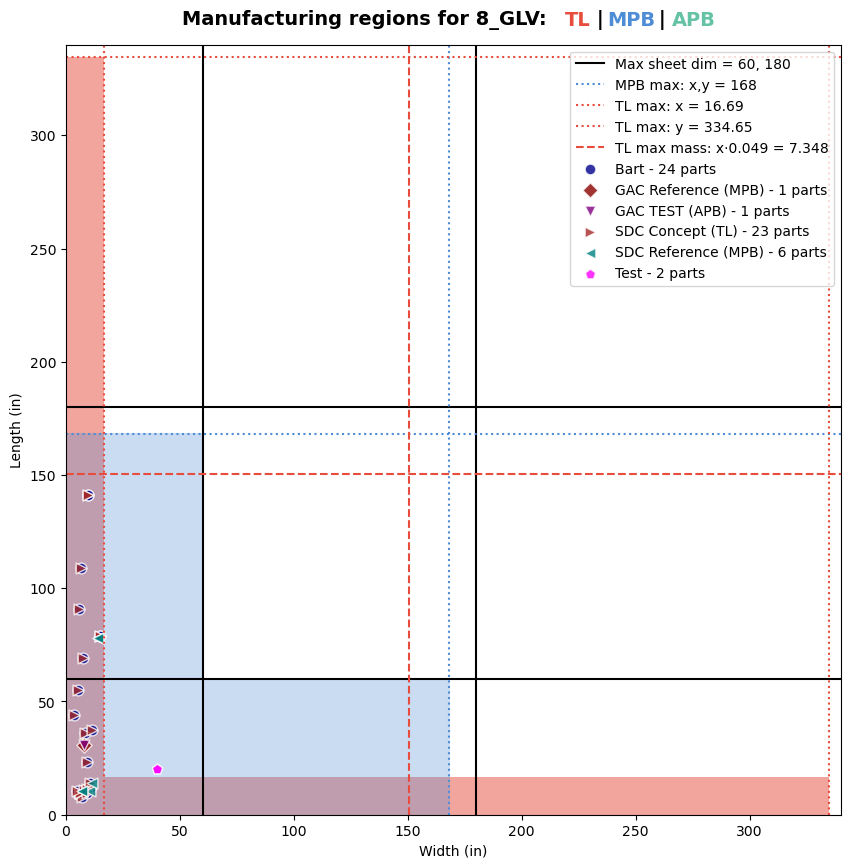

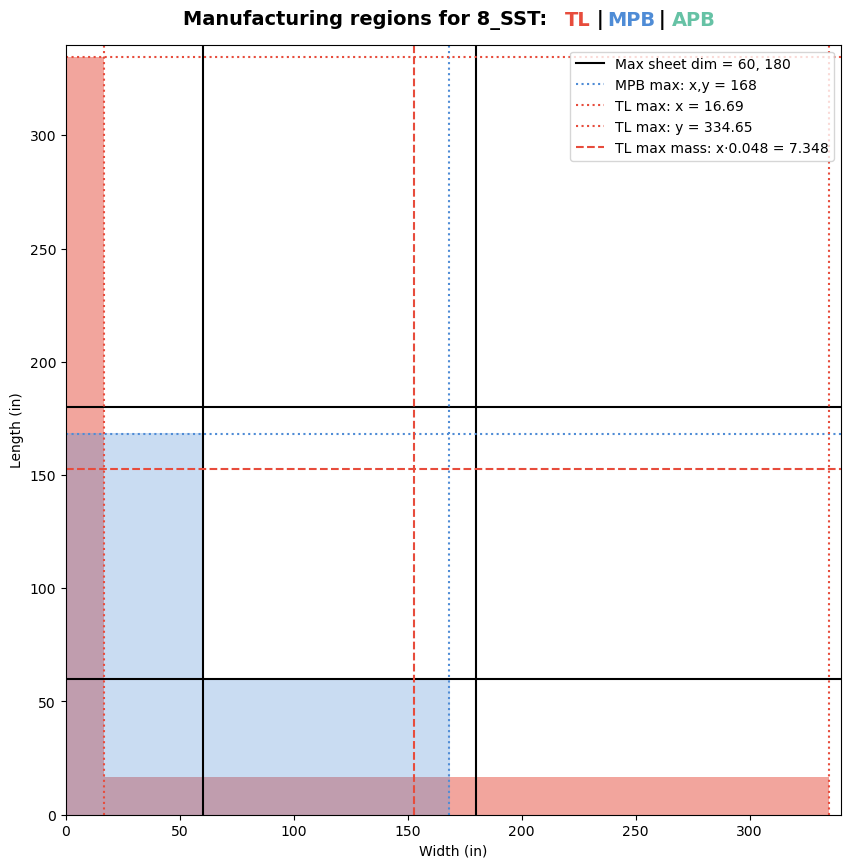

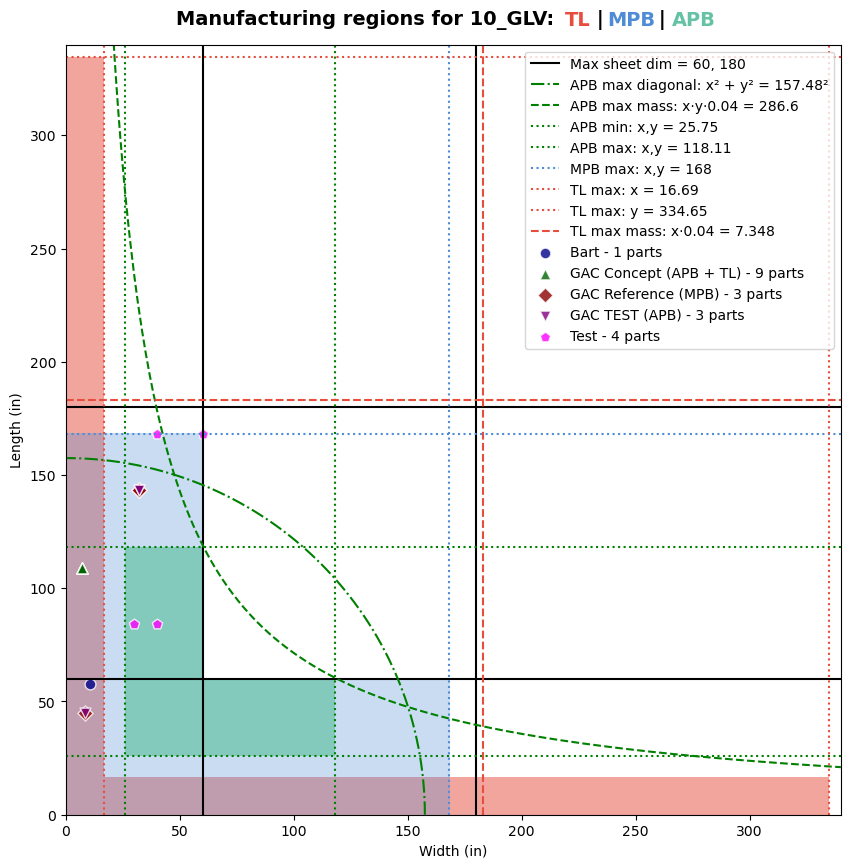

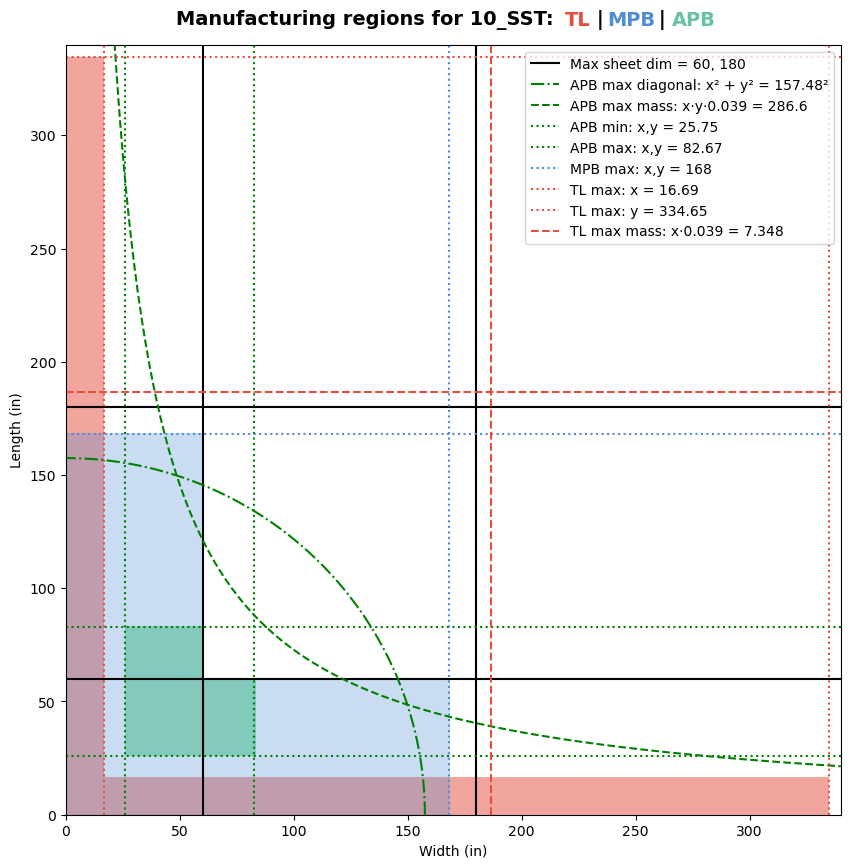

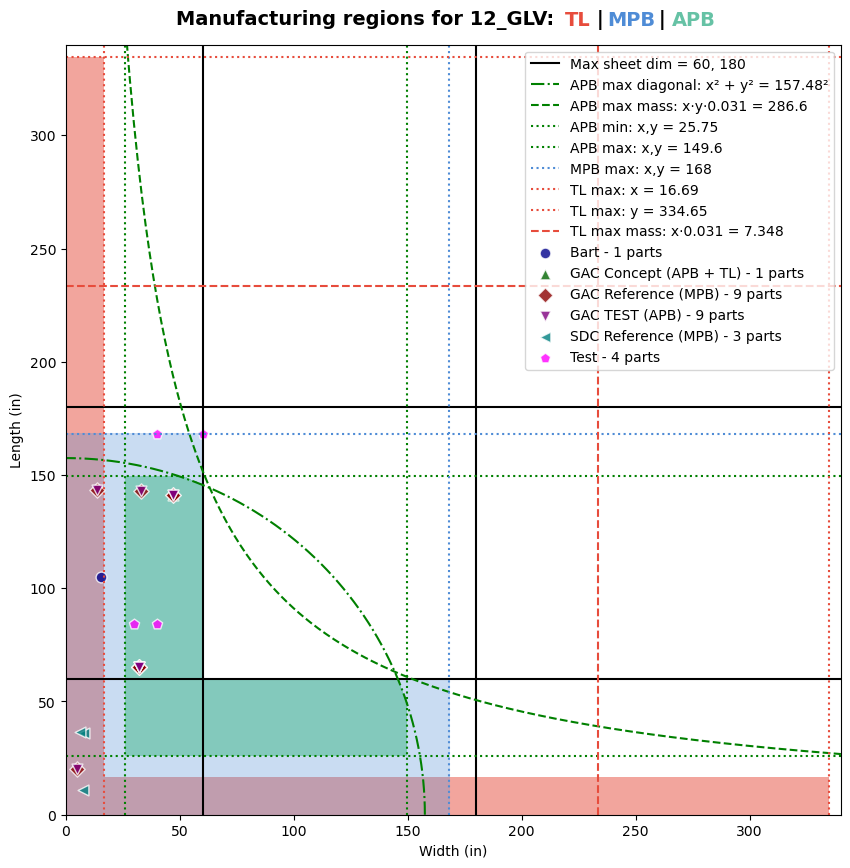

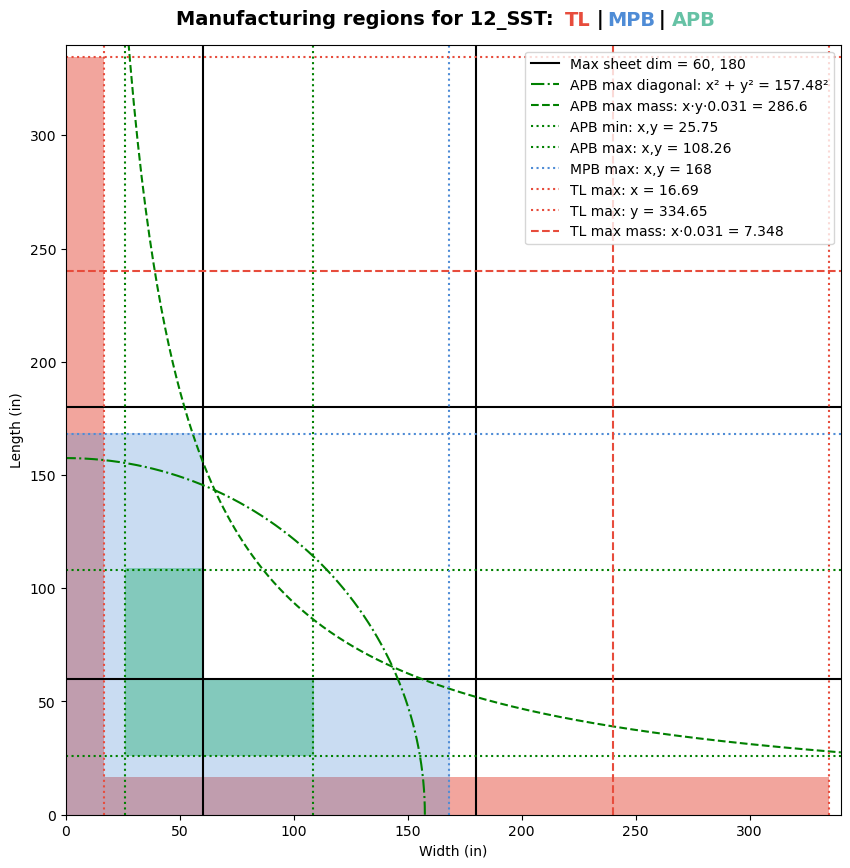

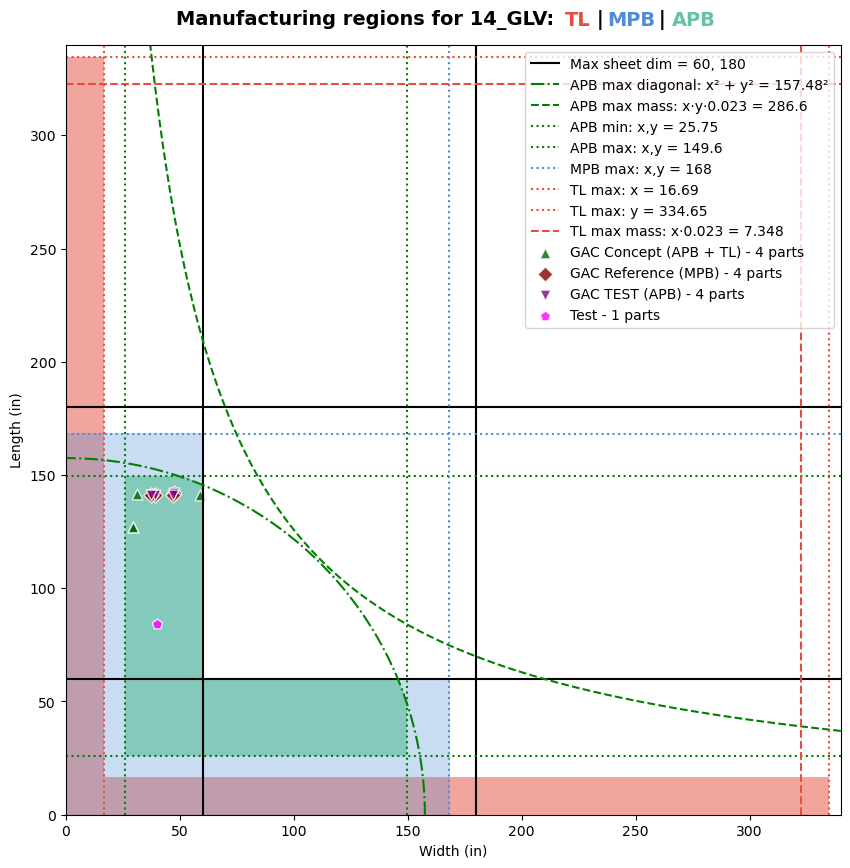

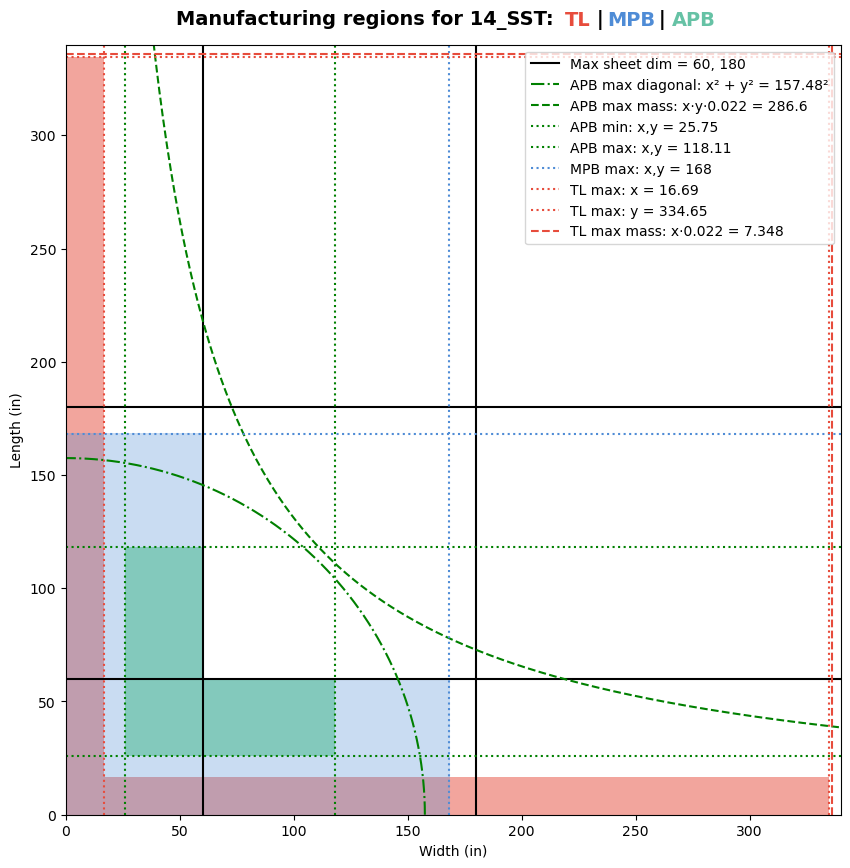

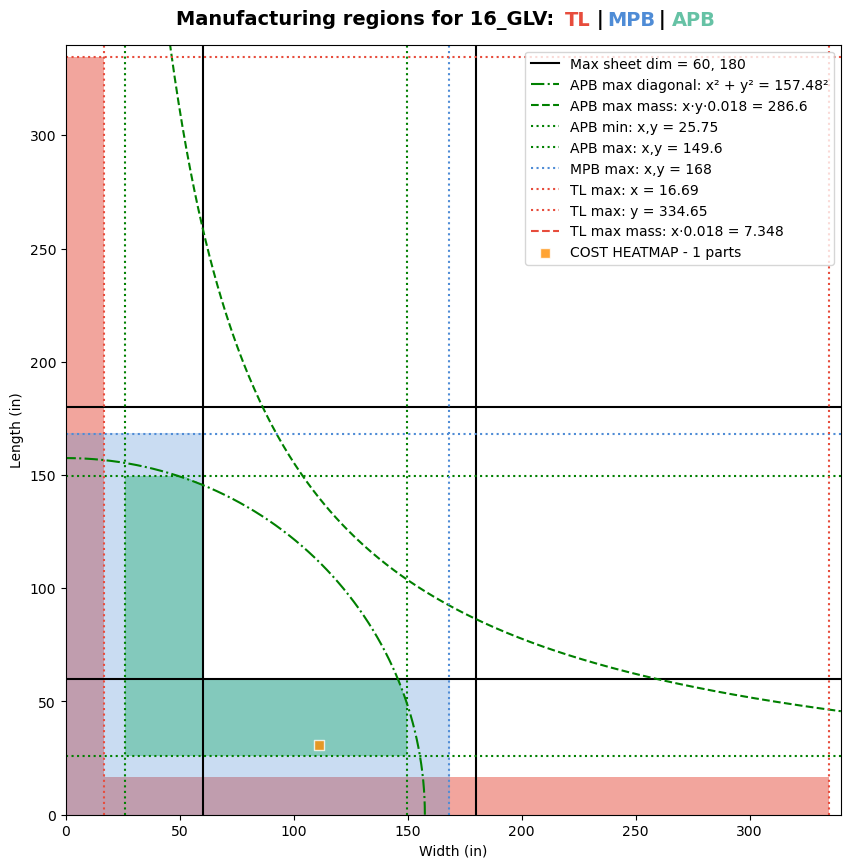

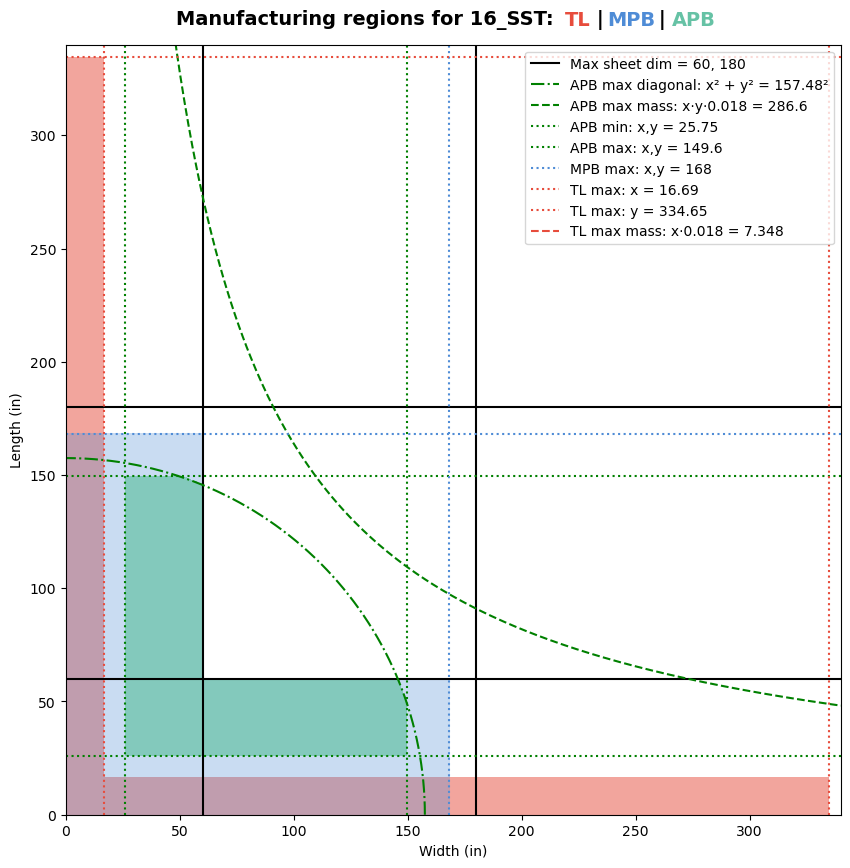

In [214]:
# gauges = df['Gauge'].apply(lambda x: int(x)).unique().tolist()
# materials = df['NCx_Material'].apply(lambda x: str(x)[:3]).unique().tolist() 
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        cap.add_part_sets(part_sets)
        cap.show_plot()

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 467
    • Optimal area: 11,339 sq in
    • Cost per sq in: $9.0915
  Cost Distribution:
    • Minimum cost: $51.61
    • Maximum cost: $464.10
    • Average cost: $220.75
    • Median cost: $209.92
    • Standard deviation: $90.71
    • 25th percentile: $149.62
    • 75th percentile: $282.29
    • Cost range span: $412.50
    • Coefficient of variation: 41.1%

TL OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 512
    • Optimal area: 12,432 sq in
    • Cost per sq in: $3.5574
  Cost Distribution:
    • Minimum cost: $5.50
    • Maximum cost: $302.73
    • Average cost: $86.38
    • Median cost: $65.29
    • Standa

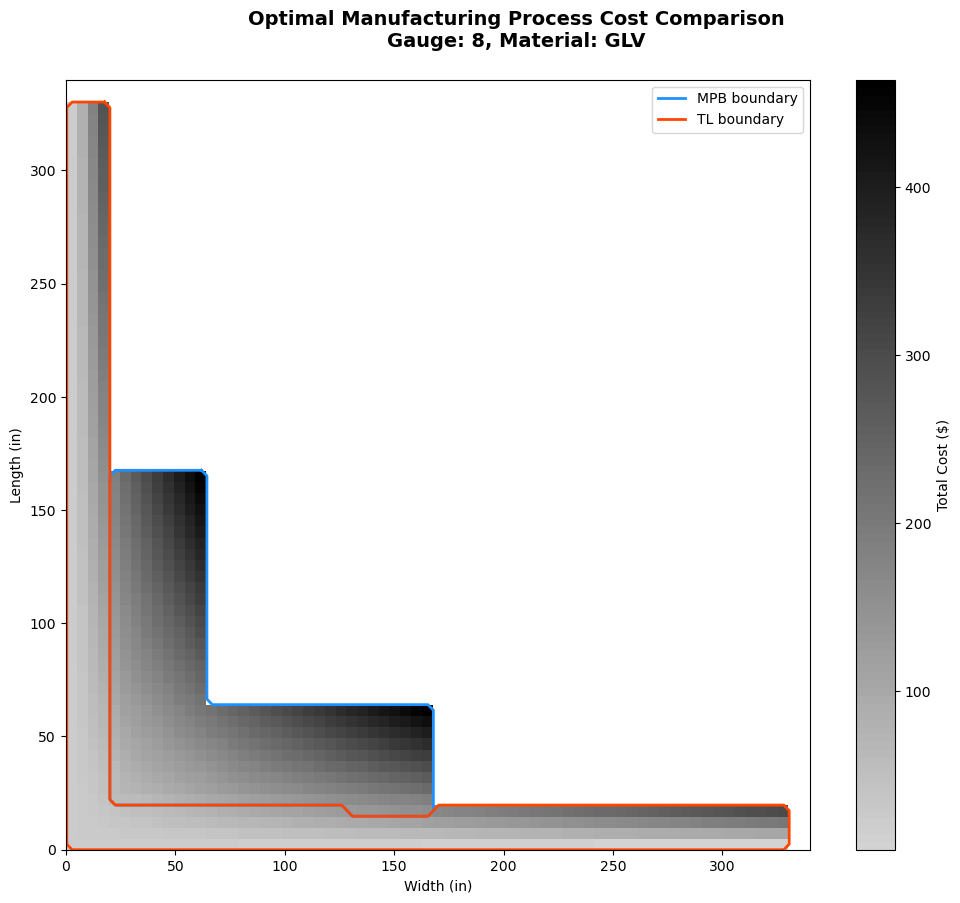

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 256 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 8
    • Win rate: 3.1%
    • Optimal area: 194 sq in
    • Cost per sq in: $5.9009
  Cost Distribution When Optimal:
    • Minimum cost: $131.45
    • Maximum cost: $155.11
    • Average cost: $143.28
    • Median cost: $143.28
    • Standard deviation: $7.73
    • 25th percentile: $137.38
    • 75th percentile: $149.18
    • Cost range span: $23.66
    • Coefficient of variation: 5.4%
  Competitive Advantage:
    • Minimum advantage: $0.58
    • Maximum advantage: $6.64
    • Average ad

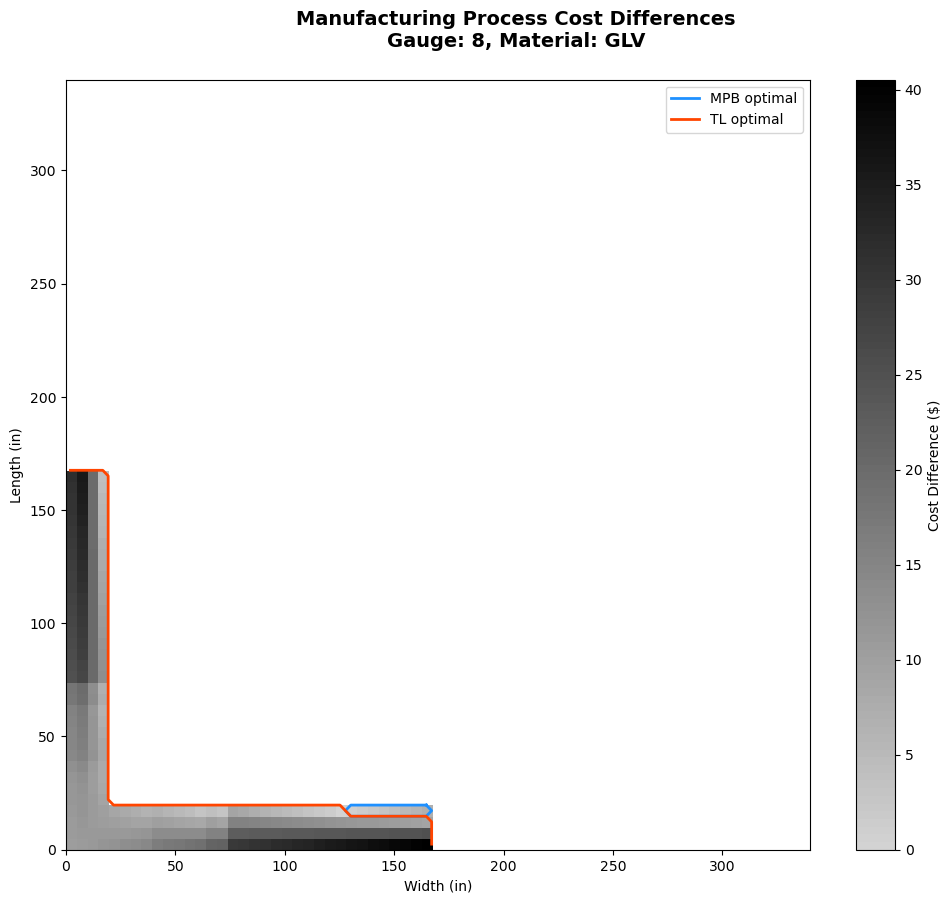

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 459
    • Optimal area: 11,145 sq in
    • Cost per sq in: $20.8225
  Cost Distribution:
    • Minimum cost: $77.70
    • Maximum cost: $1161.84
    • Average cost: $505.58
    • Median cost: $472.29
    • Standard deviation: $242.01
    • 25th percentile: $320.49
    • 75th percentile: $667.85
    • Cost range span: $1084.14
    • Coefficient of variation: 47.9%

TL OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 520
    • Optimal area: 12,626 sq in
    • Cost per sq in: $3.6884
  Cost Distribution:
    • Minimum cost: $4.62
    • Maximum cost: $312.06
    • Average cost: $89.56
    • Median cost: $67.63
    • St

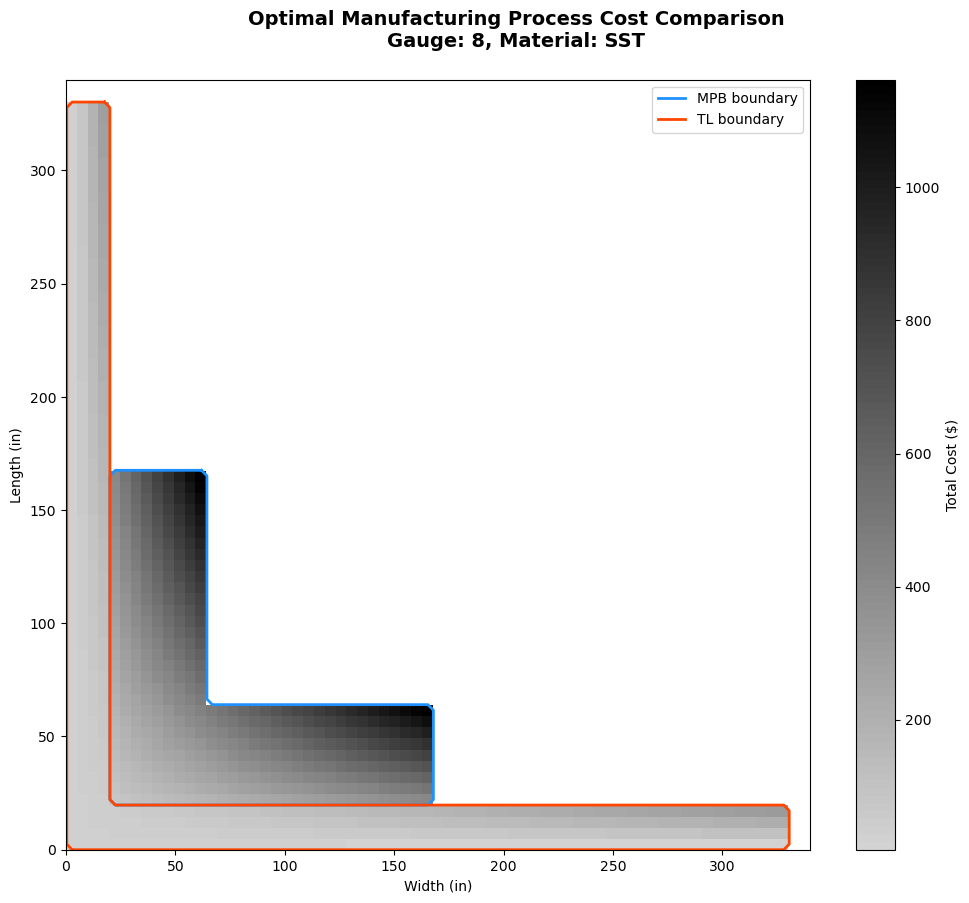

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 256 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

TL OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 256
    • Win rate: 100.0%
    • Optimal area: 6,216 sq in
    • Cost per sq in: $2.3444
  Cost Distribution When Optimal:
    • Minimum cost: $14.01
    • Maximum cost: $166.38
    • Average cost: $56.92
    • Median cost: $46.80
    • Standard deviation: $36.95
    • 25th percentile: $23.42
    • 75th percentile: $78.91
    • Cost range span: $152.38
    • Coefficient of variation: 64.9%
  Competitive Advantage:
    • Minimum advantage: $9

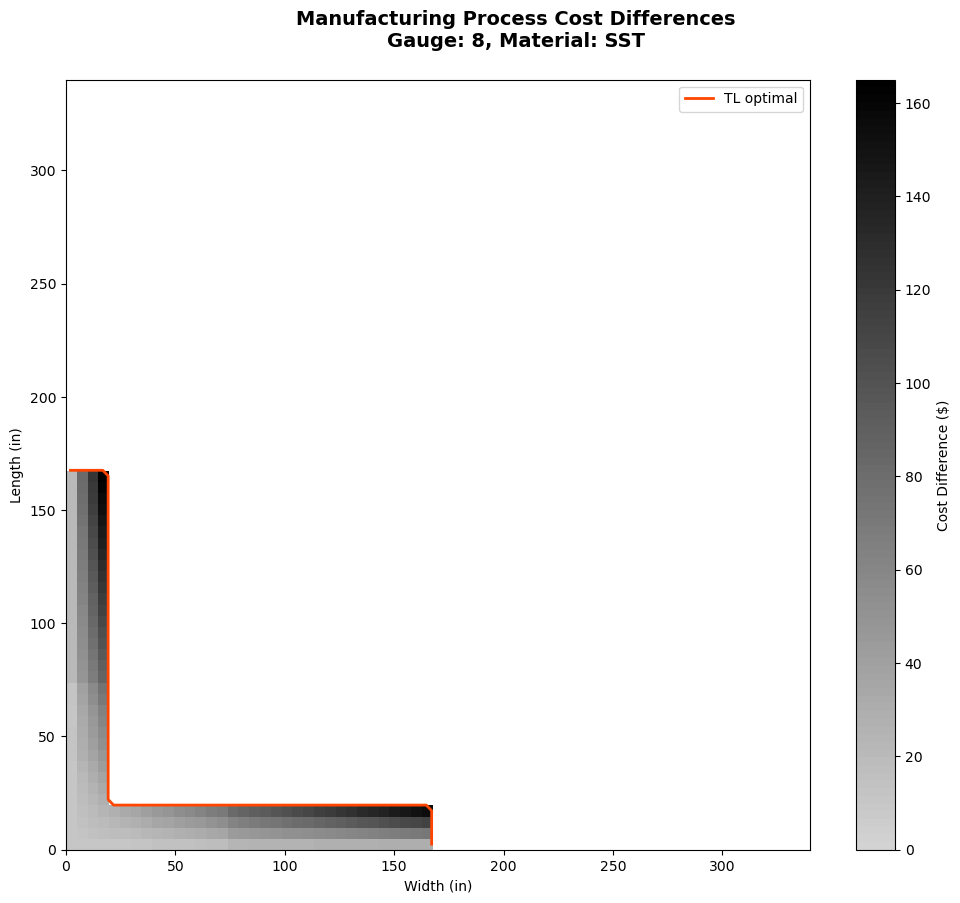

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 203
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 259
    • Optimal area: 6,289 sq in
    • Cost per sq in: $8.5976
  Cost Distribution:
    • Minimum cost: $48.77
    • Maximum cost: $401.37
    • Average cost: $208.76
    • Median cost: $204.45
    • Standard deviation: $91.57
    • 25th percentile: $132.67
    • 75th percentile: $284.51
    • Cost range span: $352.60
    • Coefficient of variation: 43.9%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 203
    • Optimal area: 4,929 sq in
    • Cost per sq in: $5.6569
  Cost Distribut

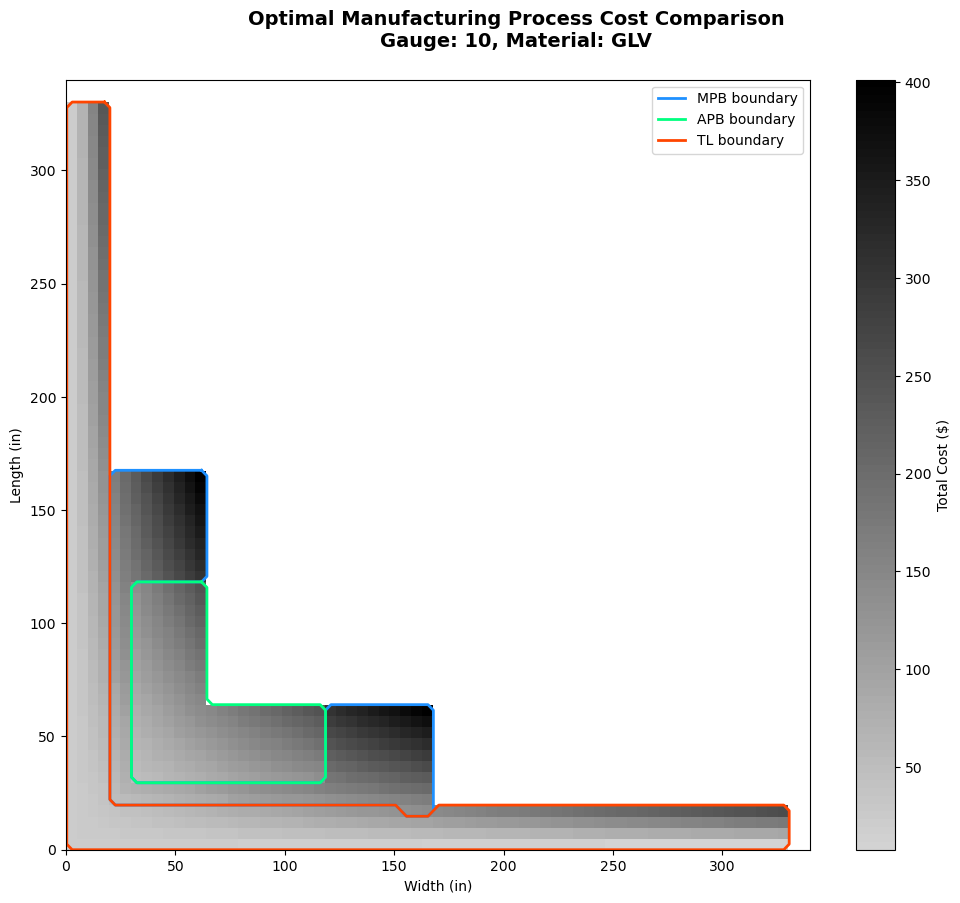

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 203
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 459 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 3
    • Win rate: 0.7%
    • Optimal area: 73 sq in
    • Cost per sq in: $5.5699
  Cost Distribution When Optimal:
    • Minimum cost: $132.38
    • Maximum cost: $138.13
    • Average cost: $135.24
    • Median cost: $135.22
    • Standard deviation: $2.35
    • 25th percentile: $133.80
    • 75th percentile: $136.67
    • Cost range span: $5.75
    • Coefficient

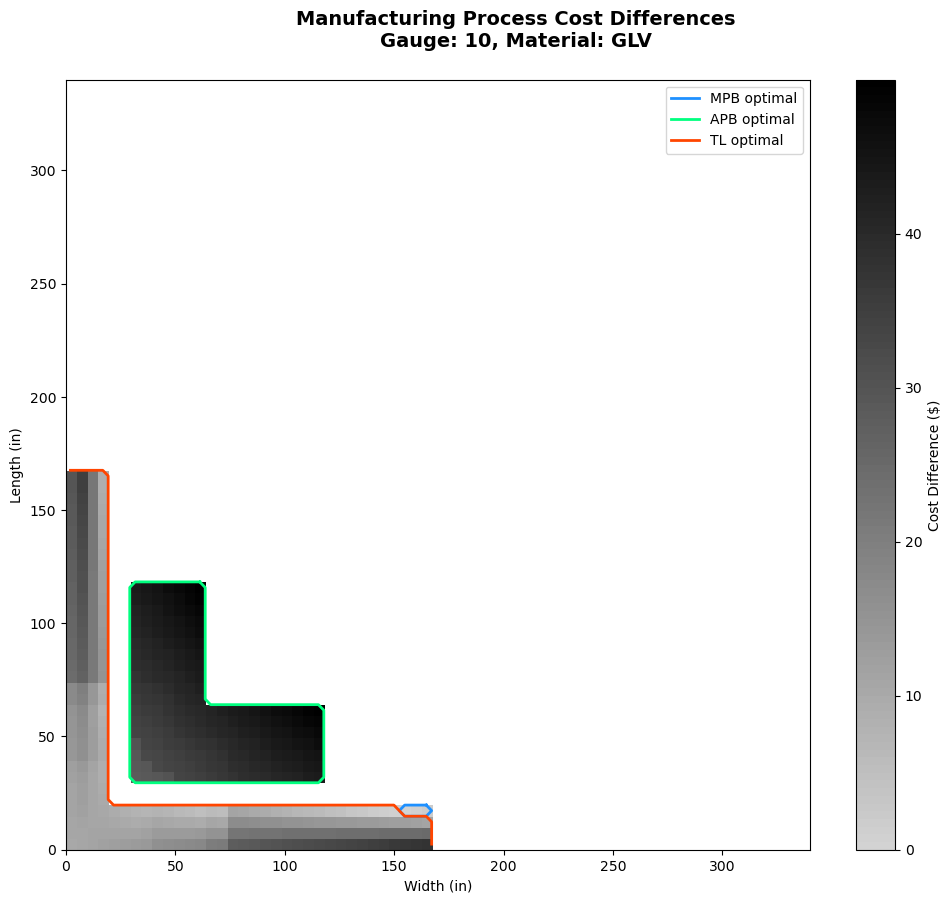

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 105
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 354
    • Optimal area: 8,595 sq in
    • Cost per sq in: $19.4045
  Cost Distribution:
    • Minimum cost: $71.46
    • Maximum cost: $979.54
    • Average cost: $471.15
    • Median cost: $463.85
    • Standard deviation: $210.08
    • 25th percentile: $318.83
    • 75th percentile: $616.01
    • Cost range span: $908.08
    • Coefficient of variation: 44.6%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 105
    • Optimal area: 2,549 sq in
    • Cost per sq in: $10.7224
  Cost Distri

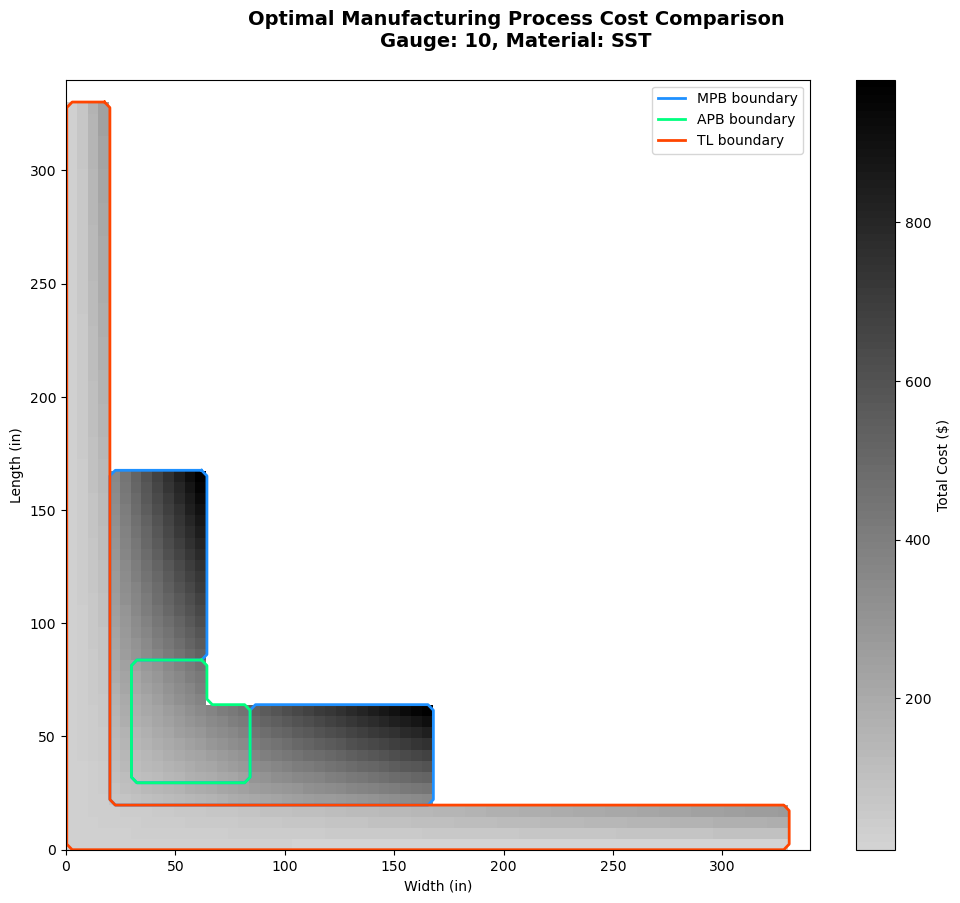

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 105
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 361 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 105
    • Win rate: 29.1%
    • Optimal area: 2,549 sq in
    • Cost per sq in: $10.7224
  Cost Distribution When Optimal:
    • Minimum cost: $98.37
    • Maximum cost: $452.73
    • Average cost: $260.35
    • Median cost: $251.77
    • Standard deviation: $86.31
    • 25th percentile: $193.18
    • 75th percentile:

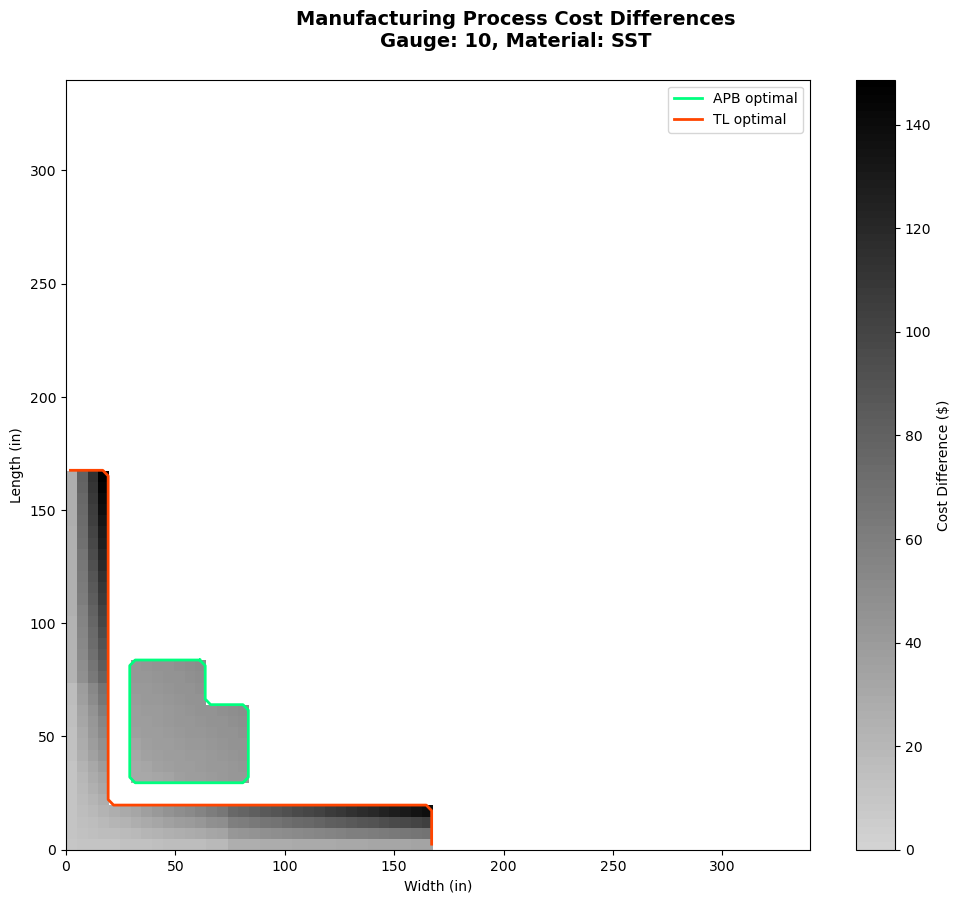

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 172
    • Optimal area: 4,176 sq in
    • Cost per sq in: $6.0314
  Cost Distribution:
    • Minimum cost: $45.34
    • Maximum cost: $311.45
    • Average cost: $146.45
    • Median cost: $126.59
    • Standard deviation: $72.52
    • 25th percentile: $89.64
    • 75th percentile: $199.43
    • Cost range span: $266.11
    • Coefficient of variation: 49.5%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 287
    • Optimal area: 6,969 sq in
    • Cost per sq in: $4.9521
  Cost Distributi

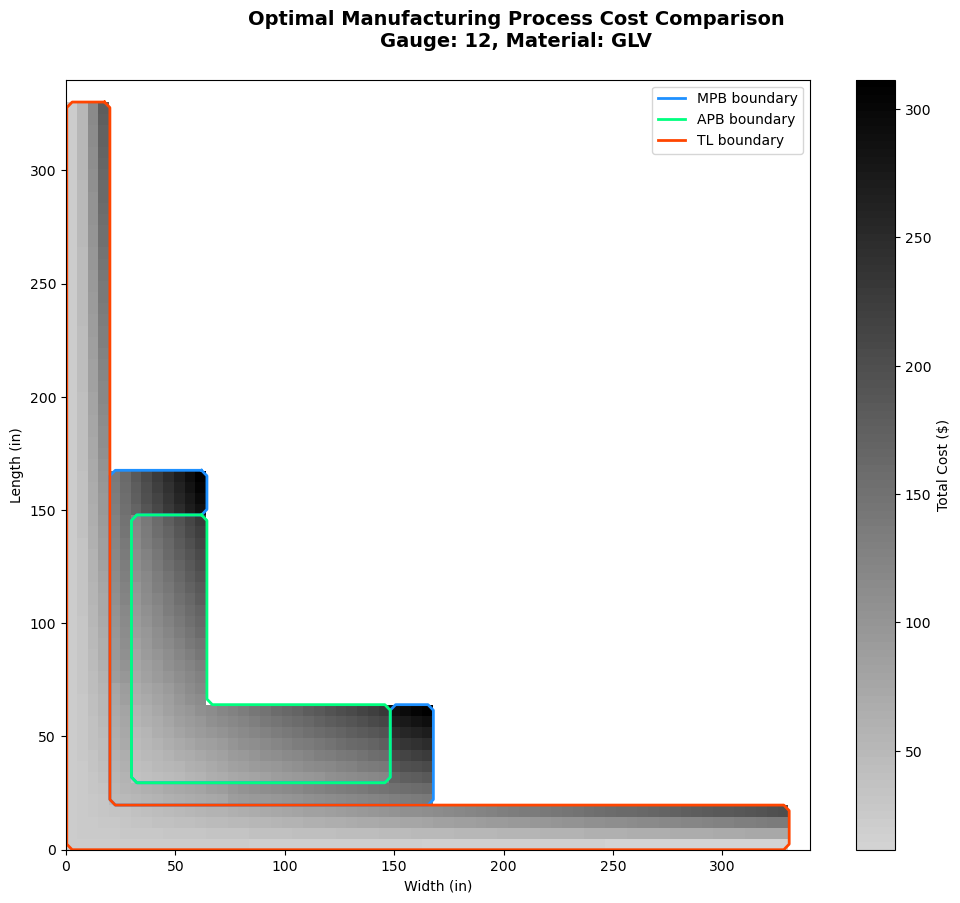

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 543 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 287
    • Win rate: 52.9%
    • Optimal area: 6,969 sq in
    • Cost per sq in: $4.9521
  Cost Distribution When Optimal:
    • Minimum cost: $35.89
    • Maximum cost: $227.77
    • Average cost: $120.24
    • Median cost: $117.70
    • Standard deviation: $43.07
    • 25th percentile: $89.94
    • 75th percentile: $

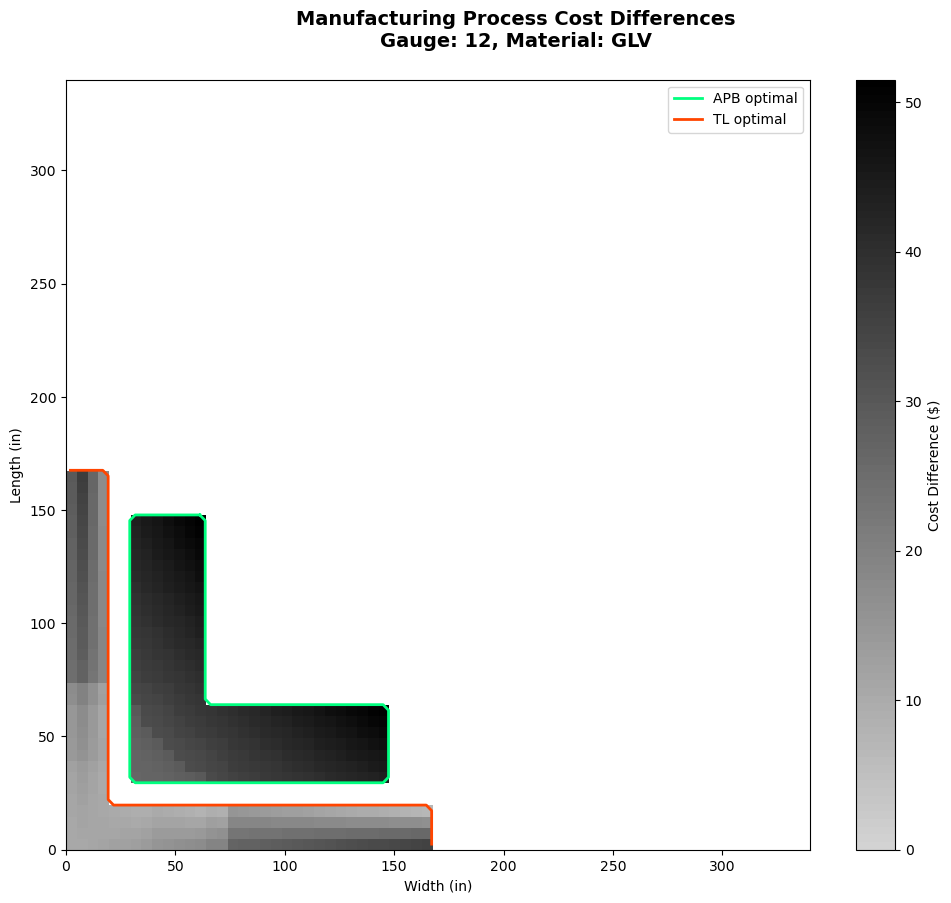

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 175
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 284
    • Optimal area: 6,896 sq in
    • Cost per sq in: $15.3104
  Cost Distribution:
    • Minimum cost: $62.14
    • Maximum cost: $761.58
    • Average cost: $371.75
    • Median cost: $367.39
    • Standard deviation: $177.10
    • 25th percentile: $225.08
    • 75th percentile: $515.41
    • Cost range span: $699.44
    • Coefficient of variation: 47.6%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 175
    • Optimal area: 4,249 sq in
    • Cost per sq in: $10.1406
  Cost Distri

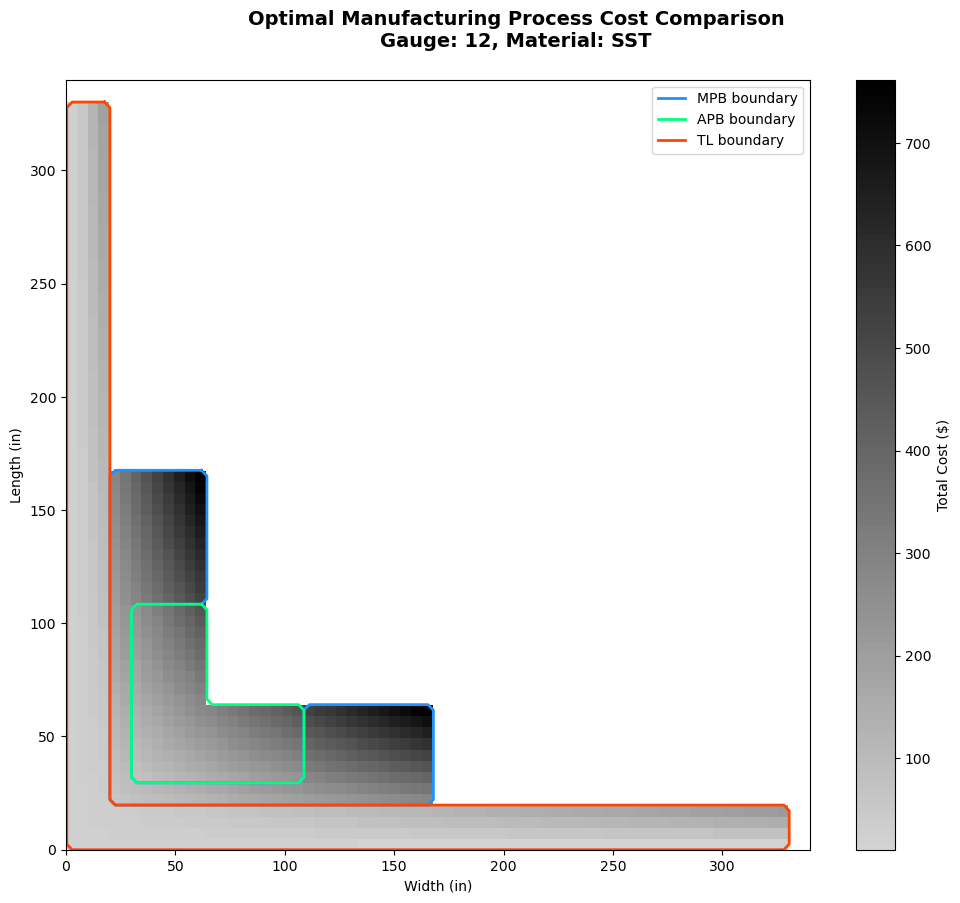

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 175
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 431 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 175
    • Win rate: 40.6%
    • Optimal area: 4,249 sq in
    • Cost per sq in: $10.1406
  Cost Distribution When Optimal:
    • Minimum cost: $75.01
    • Maximum cost: $455.47
    • Average cost: $246.22
    • Median cost: $238.73
    • Standard deviation: $87.89
    • 25th percentile: $180.98
    • 75th percentile:

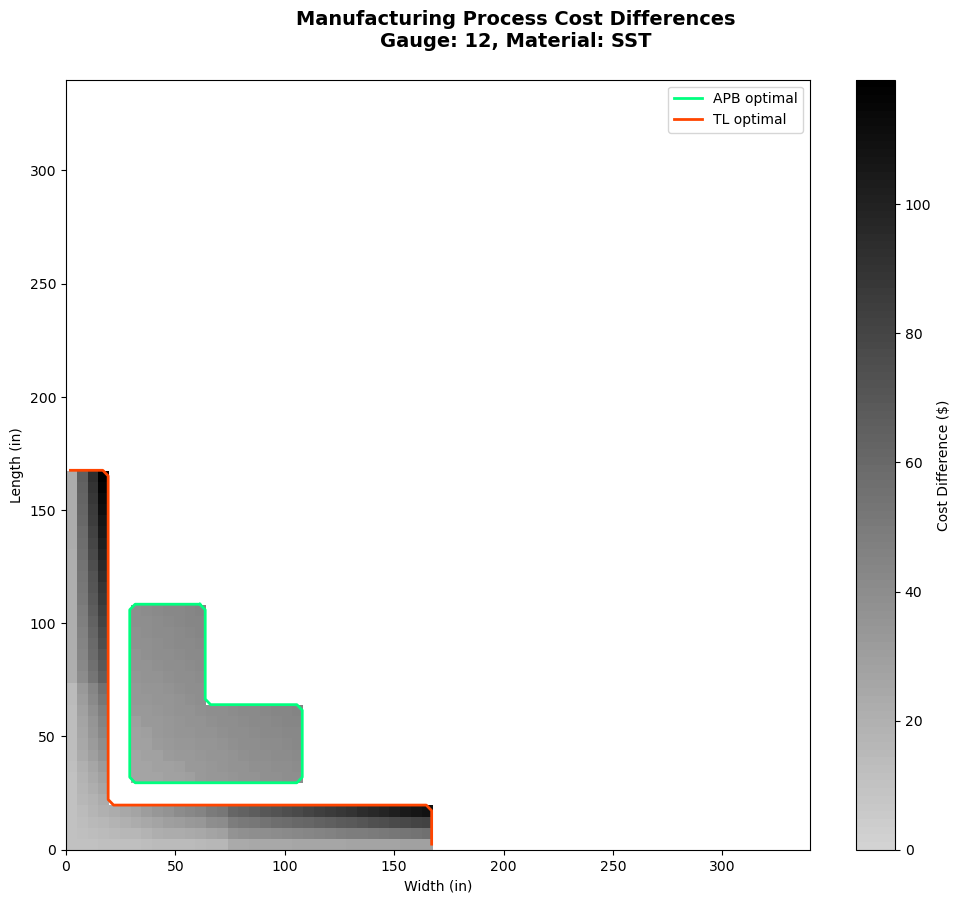

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 172
    • Optimal area: 4,176 sq in
    • Cost per sq in: $4.9647
  Cost Distribution:
    • Minimum cost: $42.68
    • Maximum cost: $242.37
    • Average cost: $120.55
    • Median cost: $106.80
    • Standard deviation: $54.24
    • 25th percentile: $78.74
    • 75th percentile: $160.64
    • Cost range span: $199.70
    • Coefficient of variation: 45.0%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 287
    • Optimal area: 6,969 sq in
    • Cost per sq in: $3.7492
  Cost Distributi

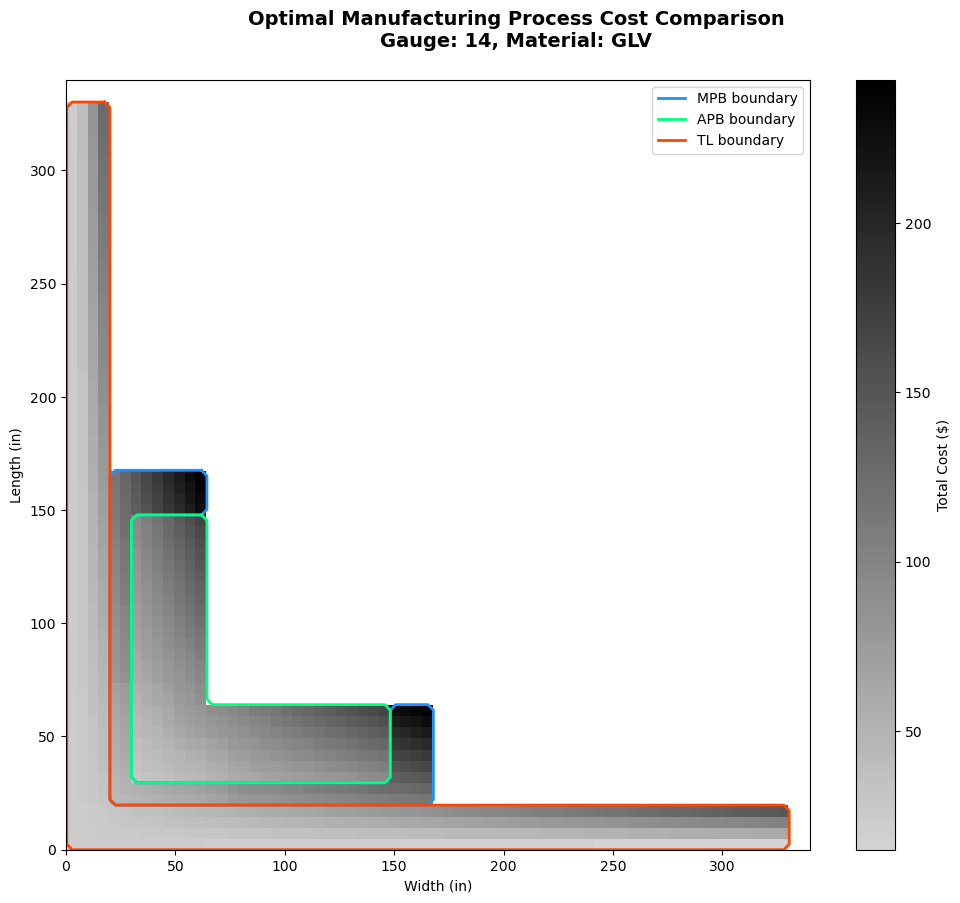

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 543 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 287
    • Win rate: 52.9%
    • Optimal area: 6,969 sq in
    • Cost per sq in: $3.7492
  Cost Distribution When Optimal:
    • Minimum cost: $29.94
    • Maximum cost: $167.69
    • Average cost: $91.03
    • Median cost: $89.44
    • Standard deviation: $30.95
    • 25th percentile: $69.75
    • 75th percentile: $11

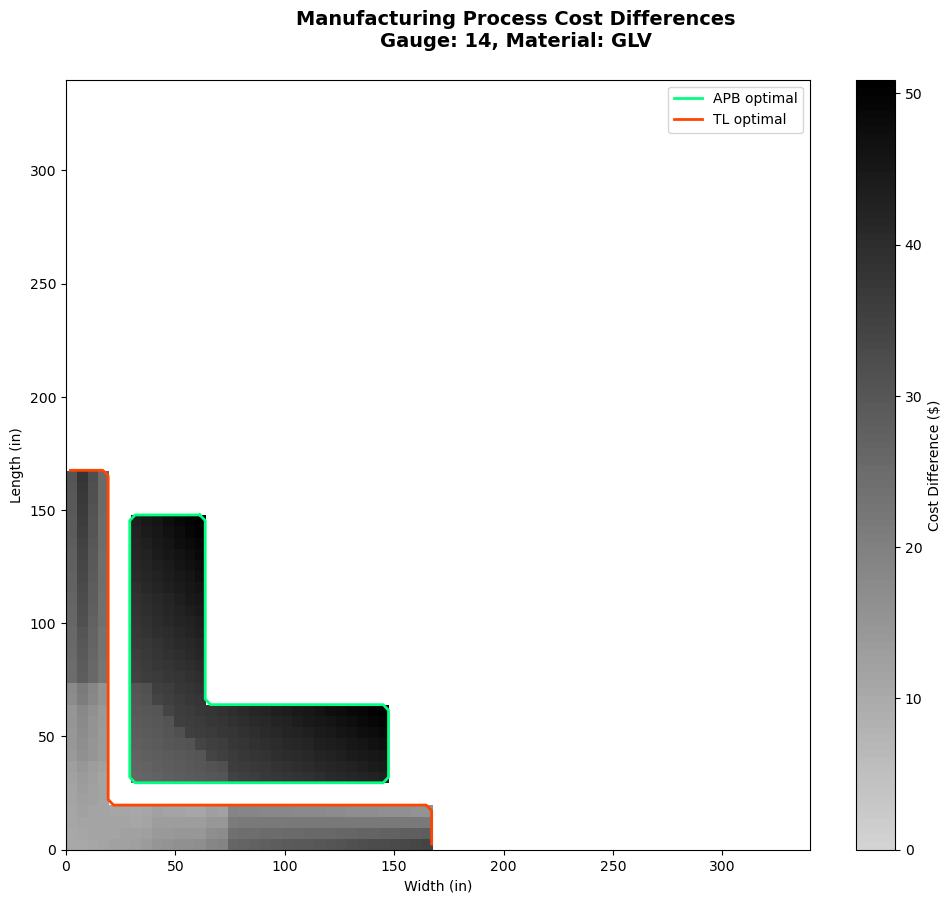

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 203
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 256
    • Optimal area: 6,216 sq in
    • Cost per sq in: $11.5534
  Cost Distribution:
    • Minimum cost: $54.77
    • Maximum cost: $567.45
    • Average cost: $280.52
    • Median cost: $272.28
    • Standard deviation: $134.55
    • 25th percentile: $166.25
    • 75th percentile: $390.95
    • Cost range span: $512.68
    • Coefficient of variation: 48.0%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 203
    • Optimal area: 4,929 sq in
    • Cost per sq in: $8.0055
  Cost Distrib

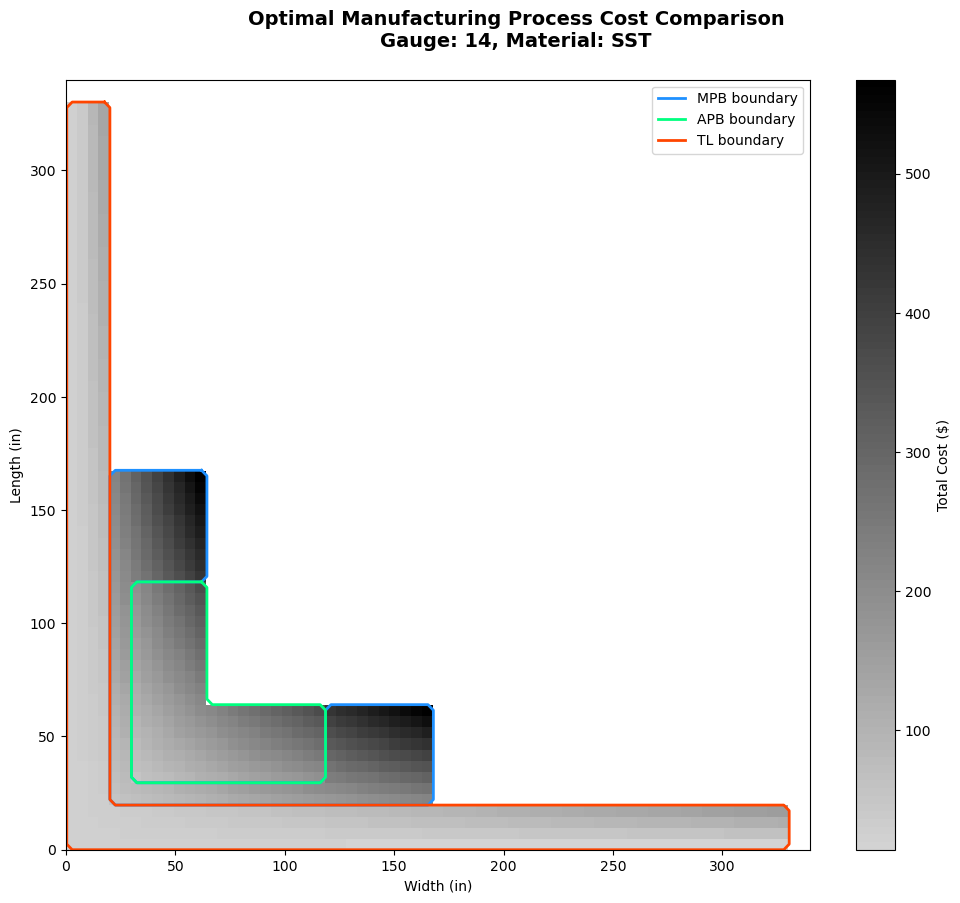

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 203
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 459 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 203
    • Win rate: 44.2%
    • Optimal area: 4,929 sq in
    • Cost per sq in: $8.0055
  Cost Distribution When Optimal:
    • Minimum cost: $58.22
    • Maximum cost: $363.08
    • Average cost: $194.38
    • Median cost: $188.86
    • Standard deviation: $69.71
    • 25th percentile: $143.41
    • 75th percentile: 

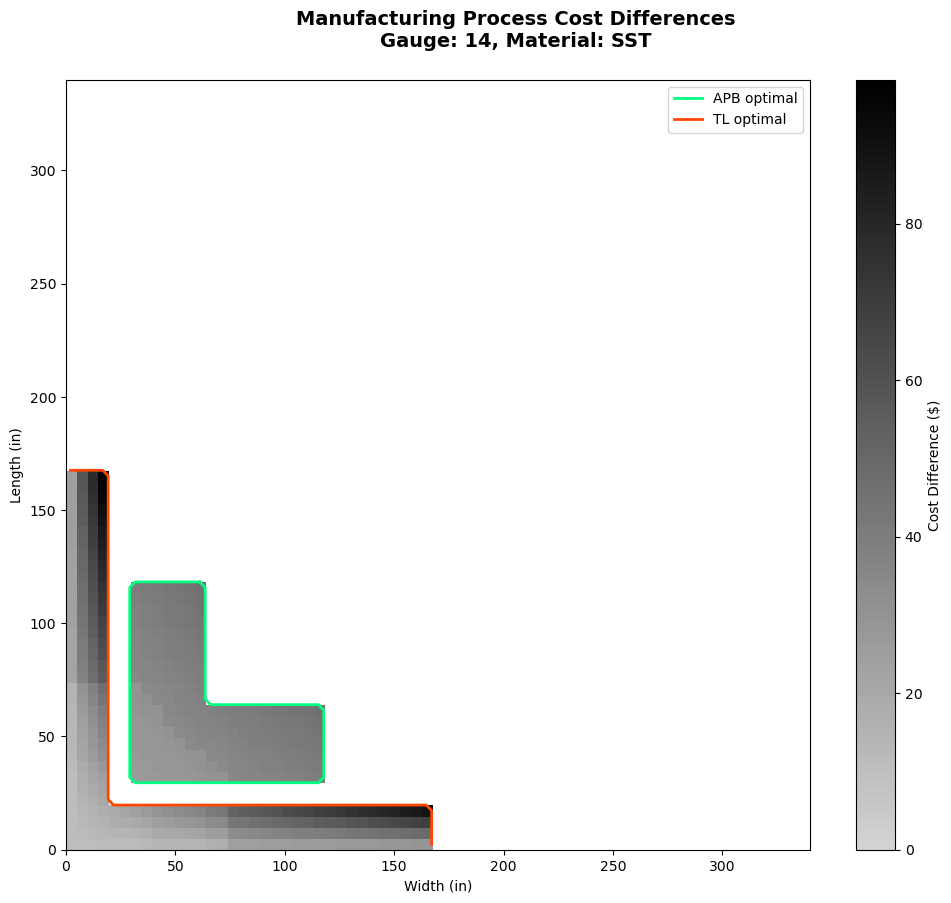

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 172
    • Optimal area: 4,176 sq in
    • Cost per sq in: $4.4800
  Cost Distribution:
    • Minimum cost: $41.44
    • Maximum cost: $211.17
    • Average cost: $108.78
    • Median cost: $97.77
    • Standard deviation: $46.00
    • 25th percentile: $73.75
    • 75th percentile: $143.04
    • Cost range span: $169.72
    • Coefficient of variation: 42.3%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 287
    • Optimal area: 6,969 sq in
    • Cost per sq in: $3.2098
  Cost Distributio

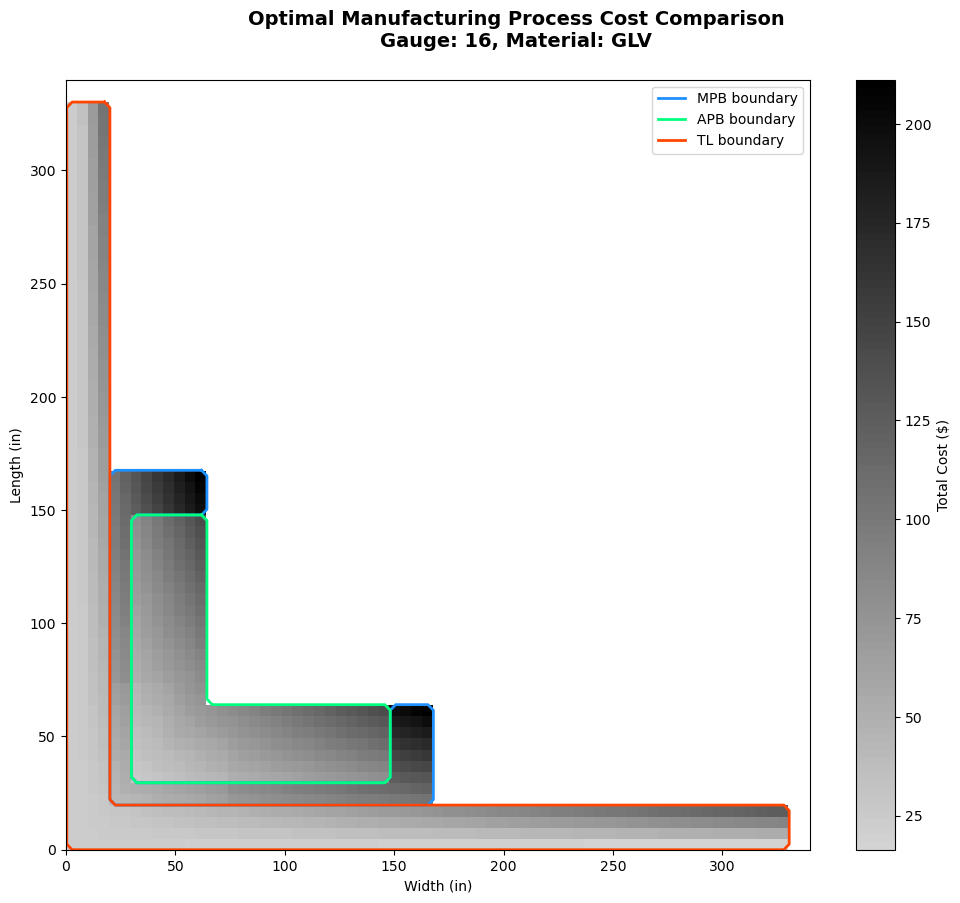

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 543 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 287
    • Win rate: 52.9%
    • Optimal area: 6,969 sq in
    • Cost per sq in: $3.2098
  Cost Distribution When Optimal:
    • Minimum cost: $27.28
    • Maximum cost: $140.76
    • Average cost: $77.94
    • Median cost: $76.77
    • Standard deviation: $25.51
    • 25th percentile: $60.50
    • 75th percentile: $95

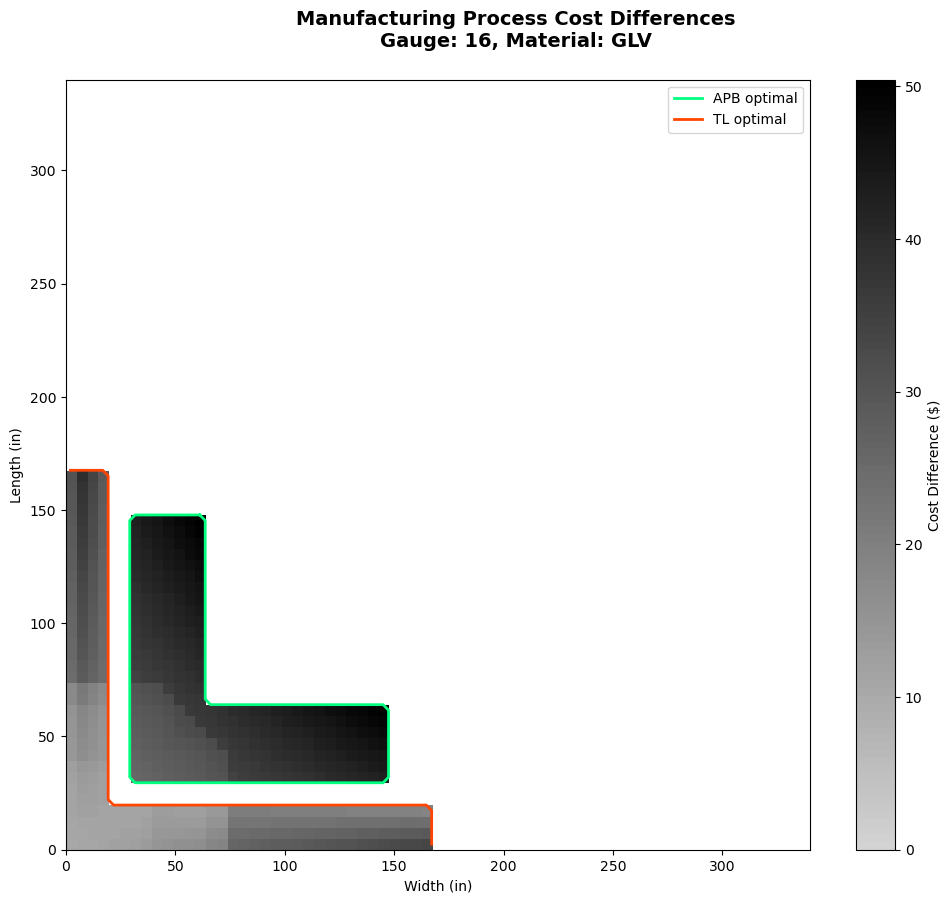

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

MPB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 172
    • Optimal area: 4,176 sq in
    • Cost per sq in: $8.3016
  Cost Distribution:
    • Minimum cost: $50.72
    • Maximum cost: $460.45
    • Average cost: $201.57
    • Median cost: $168.18
    • Standard deviation: $112.13
    • 25th percentile: $112.86
    • 75th percentile: $282.26
    • Cost range span: $409.73
    • Coefficient of variation: 55.6%

APB OPTIMAL REGION STATISTICS:
  Coverage:
    • Optimal points: 287
    • Optimal area: 6,969 sq in
    • Cost per sq in: $7.5904
  Cost Distribu

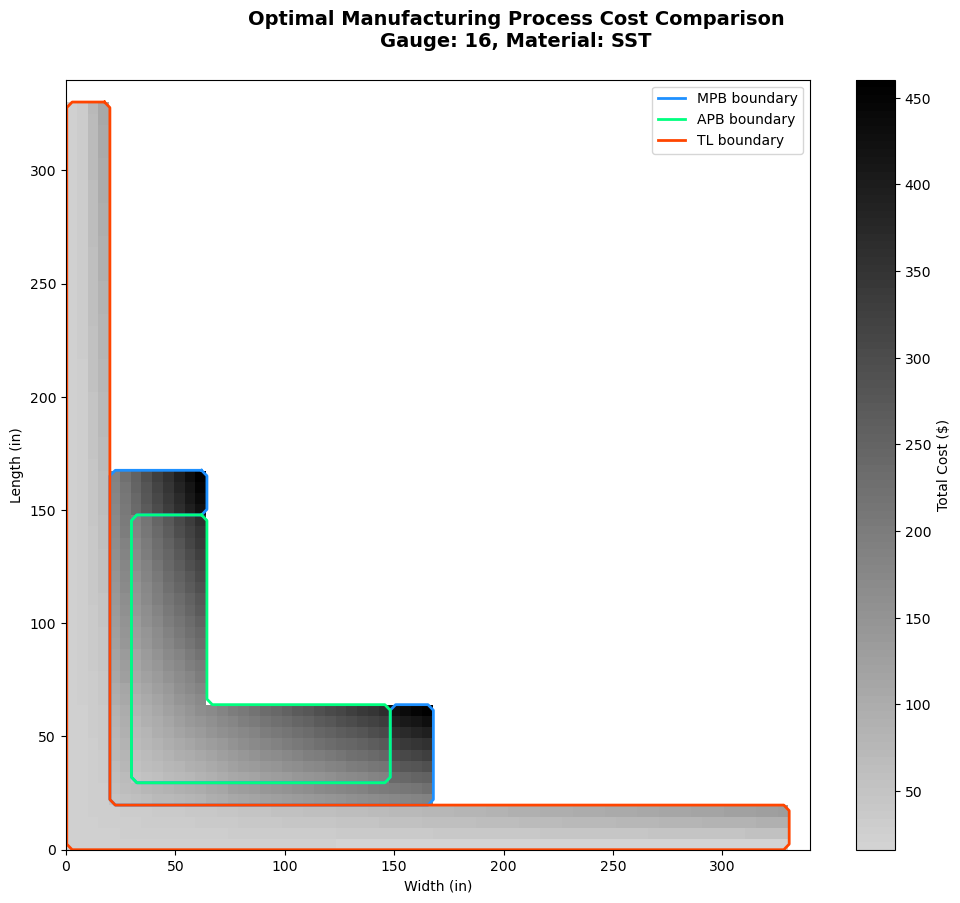

Generating costs for region: MPB
Number of feasible points: 715
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: APB
Number of feasible points: 287
Workbook opened successfully.
Workbook processed and closed.
Generating costs for region: TL
Number of feasible points: 520
Workbook opened successfully.
Workbook processed and closed.
Analyzing regions with multiple feasible processes...
Found 543 points with multiple feasible processes

COMPREHENSIVE STATISTICS FOR OPTIMAL REGIONS IN COMPETITIVE AREAS

MPB REGION: Never optimal in competitive areas

APB OPTIMAL REGION (COMPETITIVE AREAS):
  Coverage & Performance:
    • Times optimal: 287
    • Win rate: 52.9%
    • Optimal area: 6,969 sq in
    • Cost per sq in: $7.5904
  Cost Distribution When Optimal:
    • Minimum cost: $48.96
    • Maximum cost: $359.81
    • Average cost: $184.30
    • Median cost: $179.80
    • Standard deviation: $69.89
    • 25th percentile: $134.33
    • 75th percentile: 

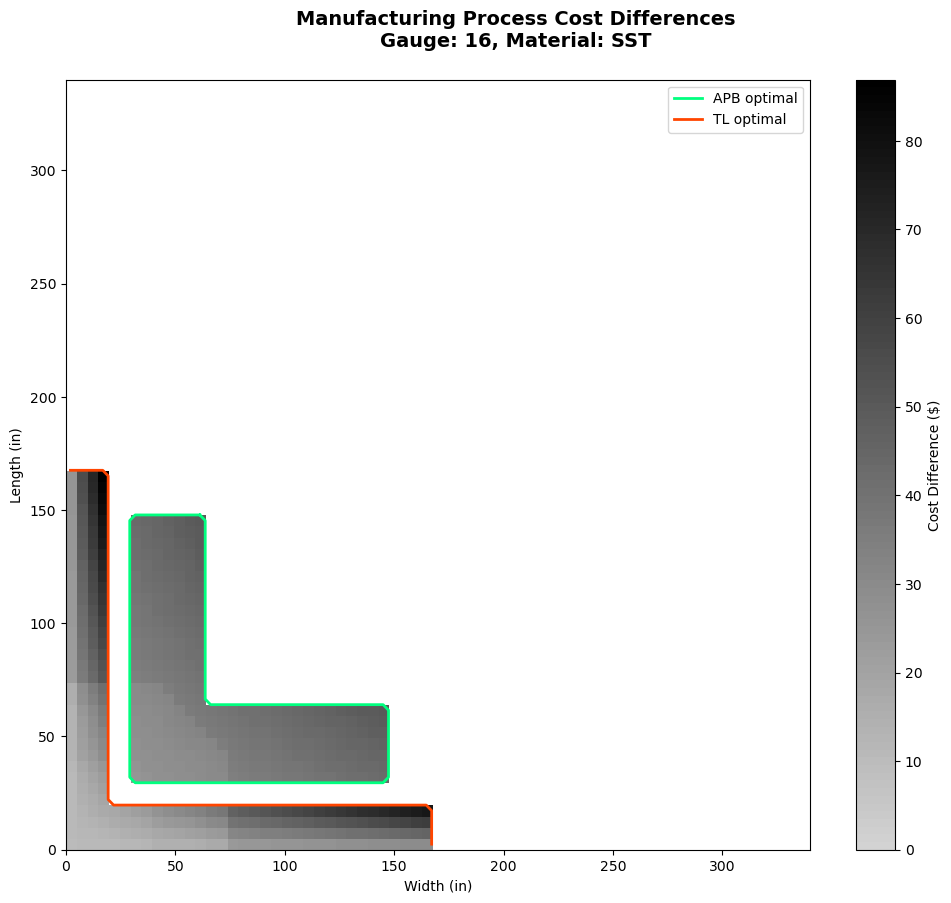

In [215]:
for app in xw.apps:
    app.quit()

fastener_spacing = 3  # Example value, adjust as needed
bolt_diameter = 0.3125  # Example value, adjust as needed

for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_optimal_cost_heatmap(path, fastener_spacing, bolt_diameter)
        cap.plot_cost_difference_heatmap(path, fastener_spacing, bolt_diameter)

